# Nanodegree Engenheiro de Machine Learning
## Projeto de conclusão de curso Engenheiro de Machine Learning
## Detecção de fraude de cartão de crédito usando * Autoencoders *

Nome: Danilo da Silva Ciciliotti - E-mail: danilociciliotti@ucl.br - Cel 27999348830 - Versão Python 3.7.0
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [104]:
# Importe as bibliotecas necessárias para o projeto.
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from imblearn.metrics import classification_report_imbalanced
from imblearn import pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 20, 10
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [105]:
# Carregamento dos dados
df = pd.read_csv("data/creditcard.csv")

# EDA - Análise Exploratória de Dados

Vamos começar a dar uma olhada nos dados para extrair informações úteis e entender as informações disponíveis.

In [106]:
# Imprimir o número de linhas e features do conjunto de dados
df.shape

(284807, 31)

Temos 31 colunas: Time, V1, V2, ..., V28, quantidade e classe. Vamos verificar os valores ausentes:

In [107]:
# Check se algum valor é nulo
df.isnull (). values.any ()

False

Verificação das distribuições dos dados

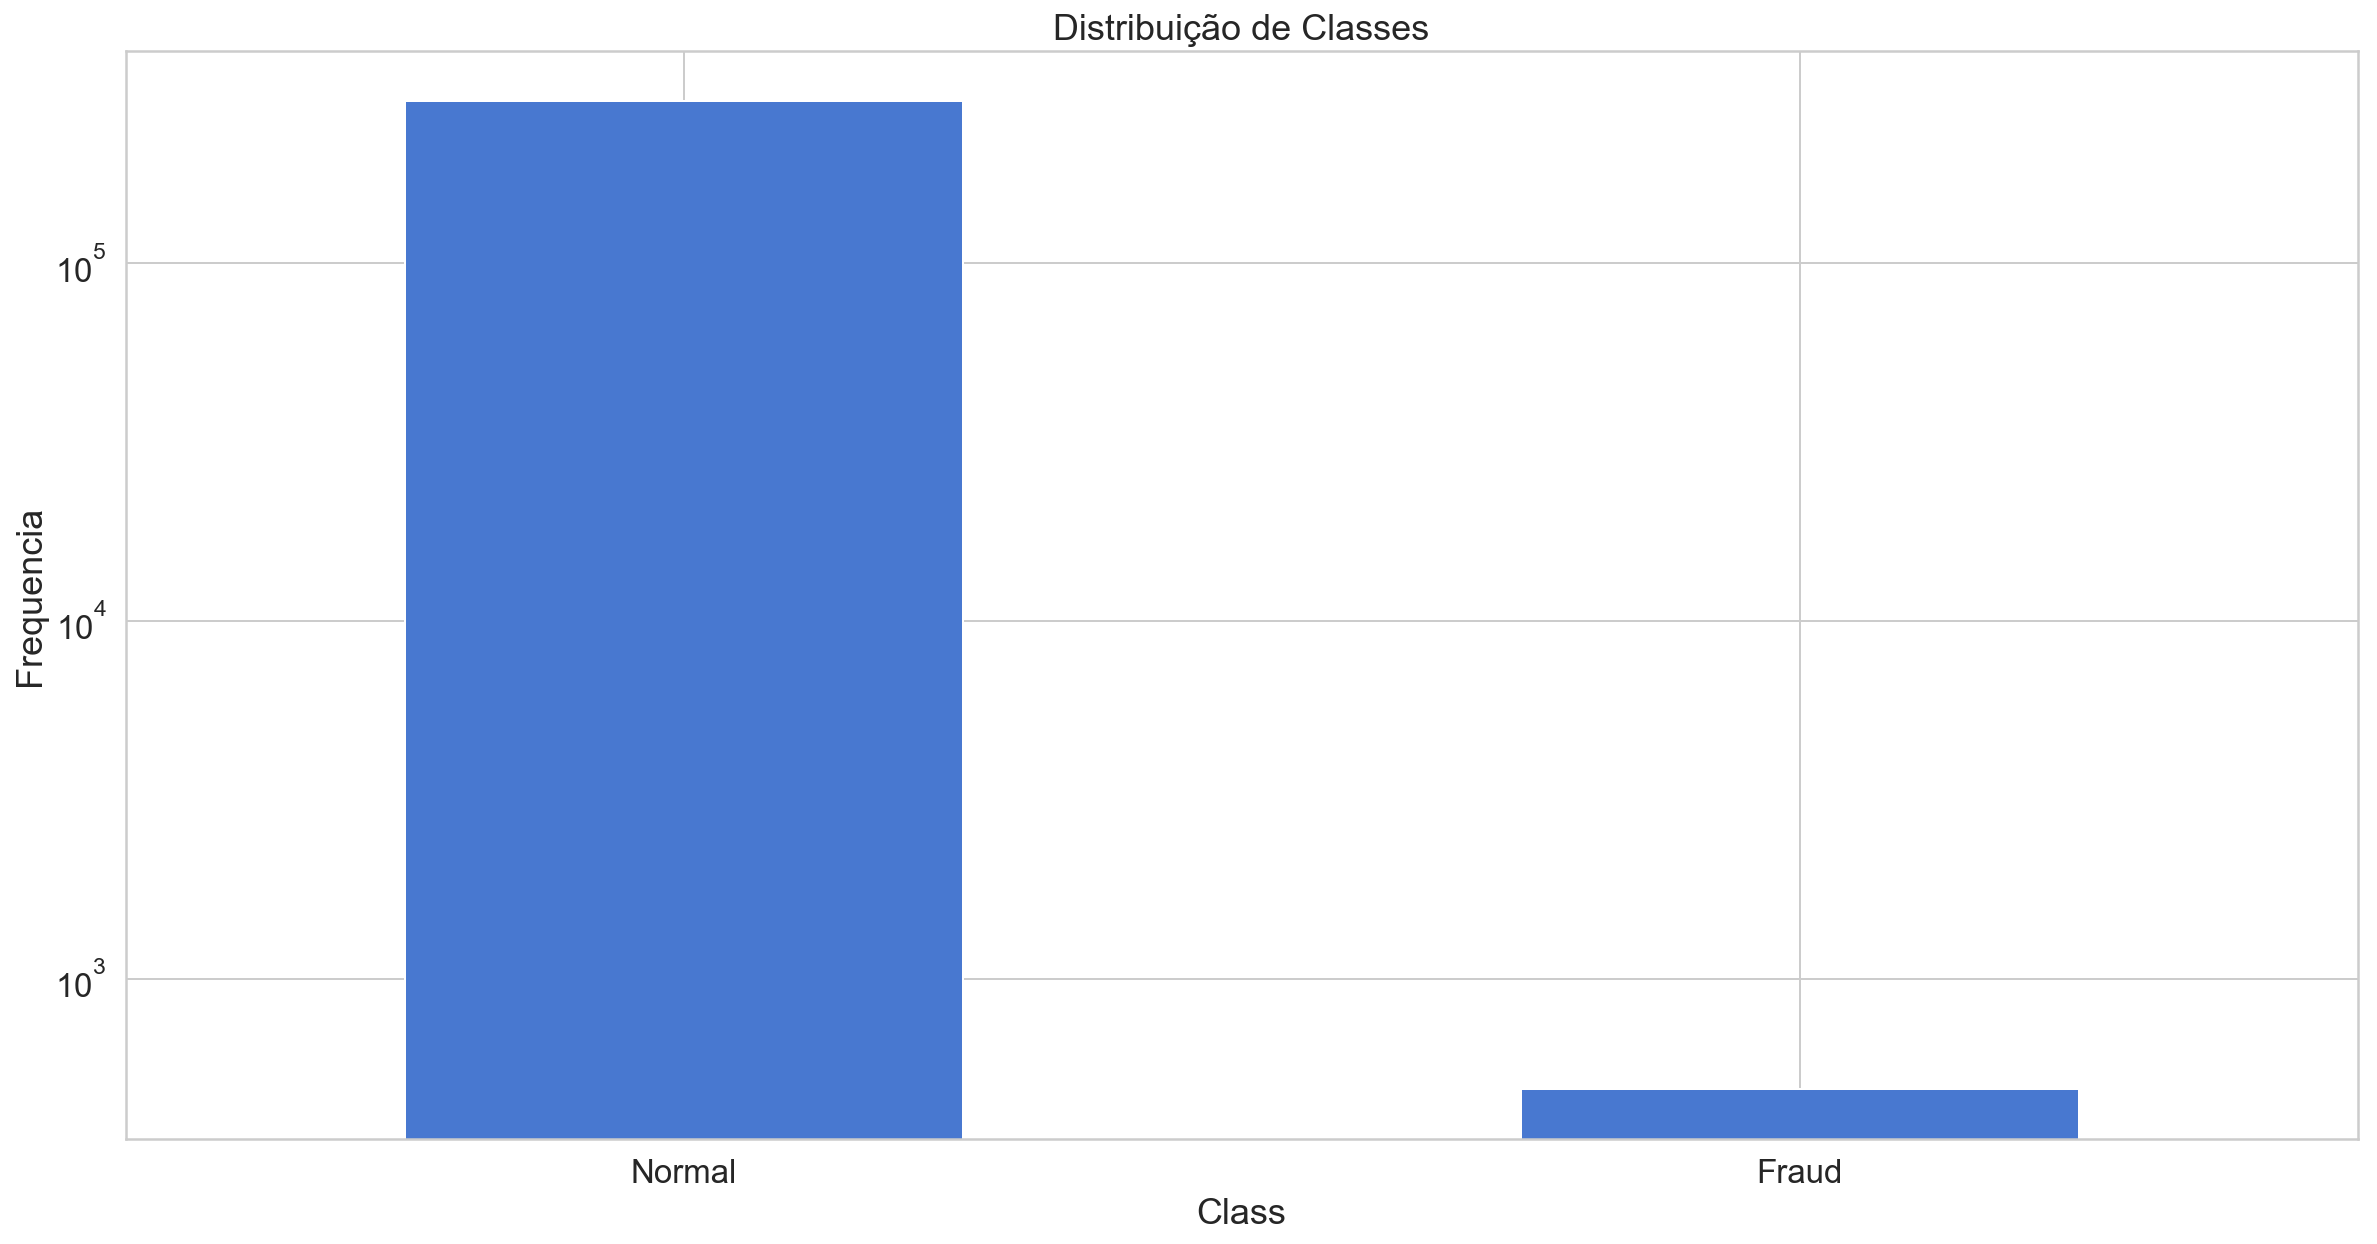

In [108]:
# Traçar a distribuição de cada classe em uma escala de log
number_of_classes = pd.value_counts(df['Class'], sort = True)
number_of_classes.plot(kind = 'bar', rot=0)
plt.title("Distribuição de Classes")
plt.xticks(range(len(number_of_classes)), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequencia");
plt.yscale('log')

In [109]:
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
print("Normal: {}, Fraudes: {}".format(normal.shape[0], fraud.shape[0]))

Normal: 284315, Fraudes: 492


Temos um conjunto de dados altamente desequilibrado. Assim, precisamos realizar alguma forma de aumento de dados! 
Vejamos a distribuição do Amout por transação das duas classes.

In [110]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [111]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

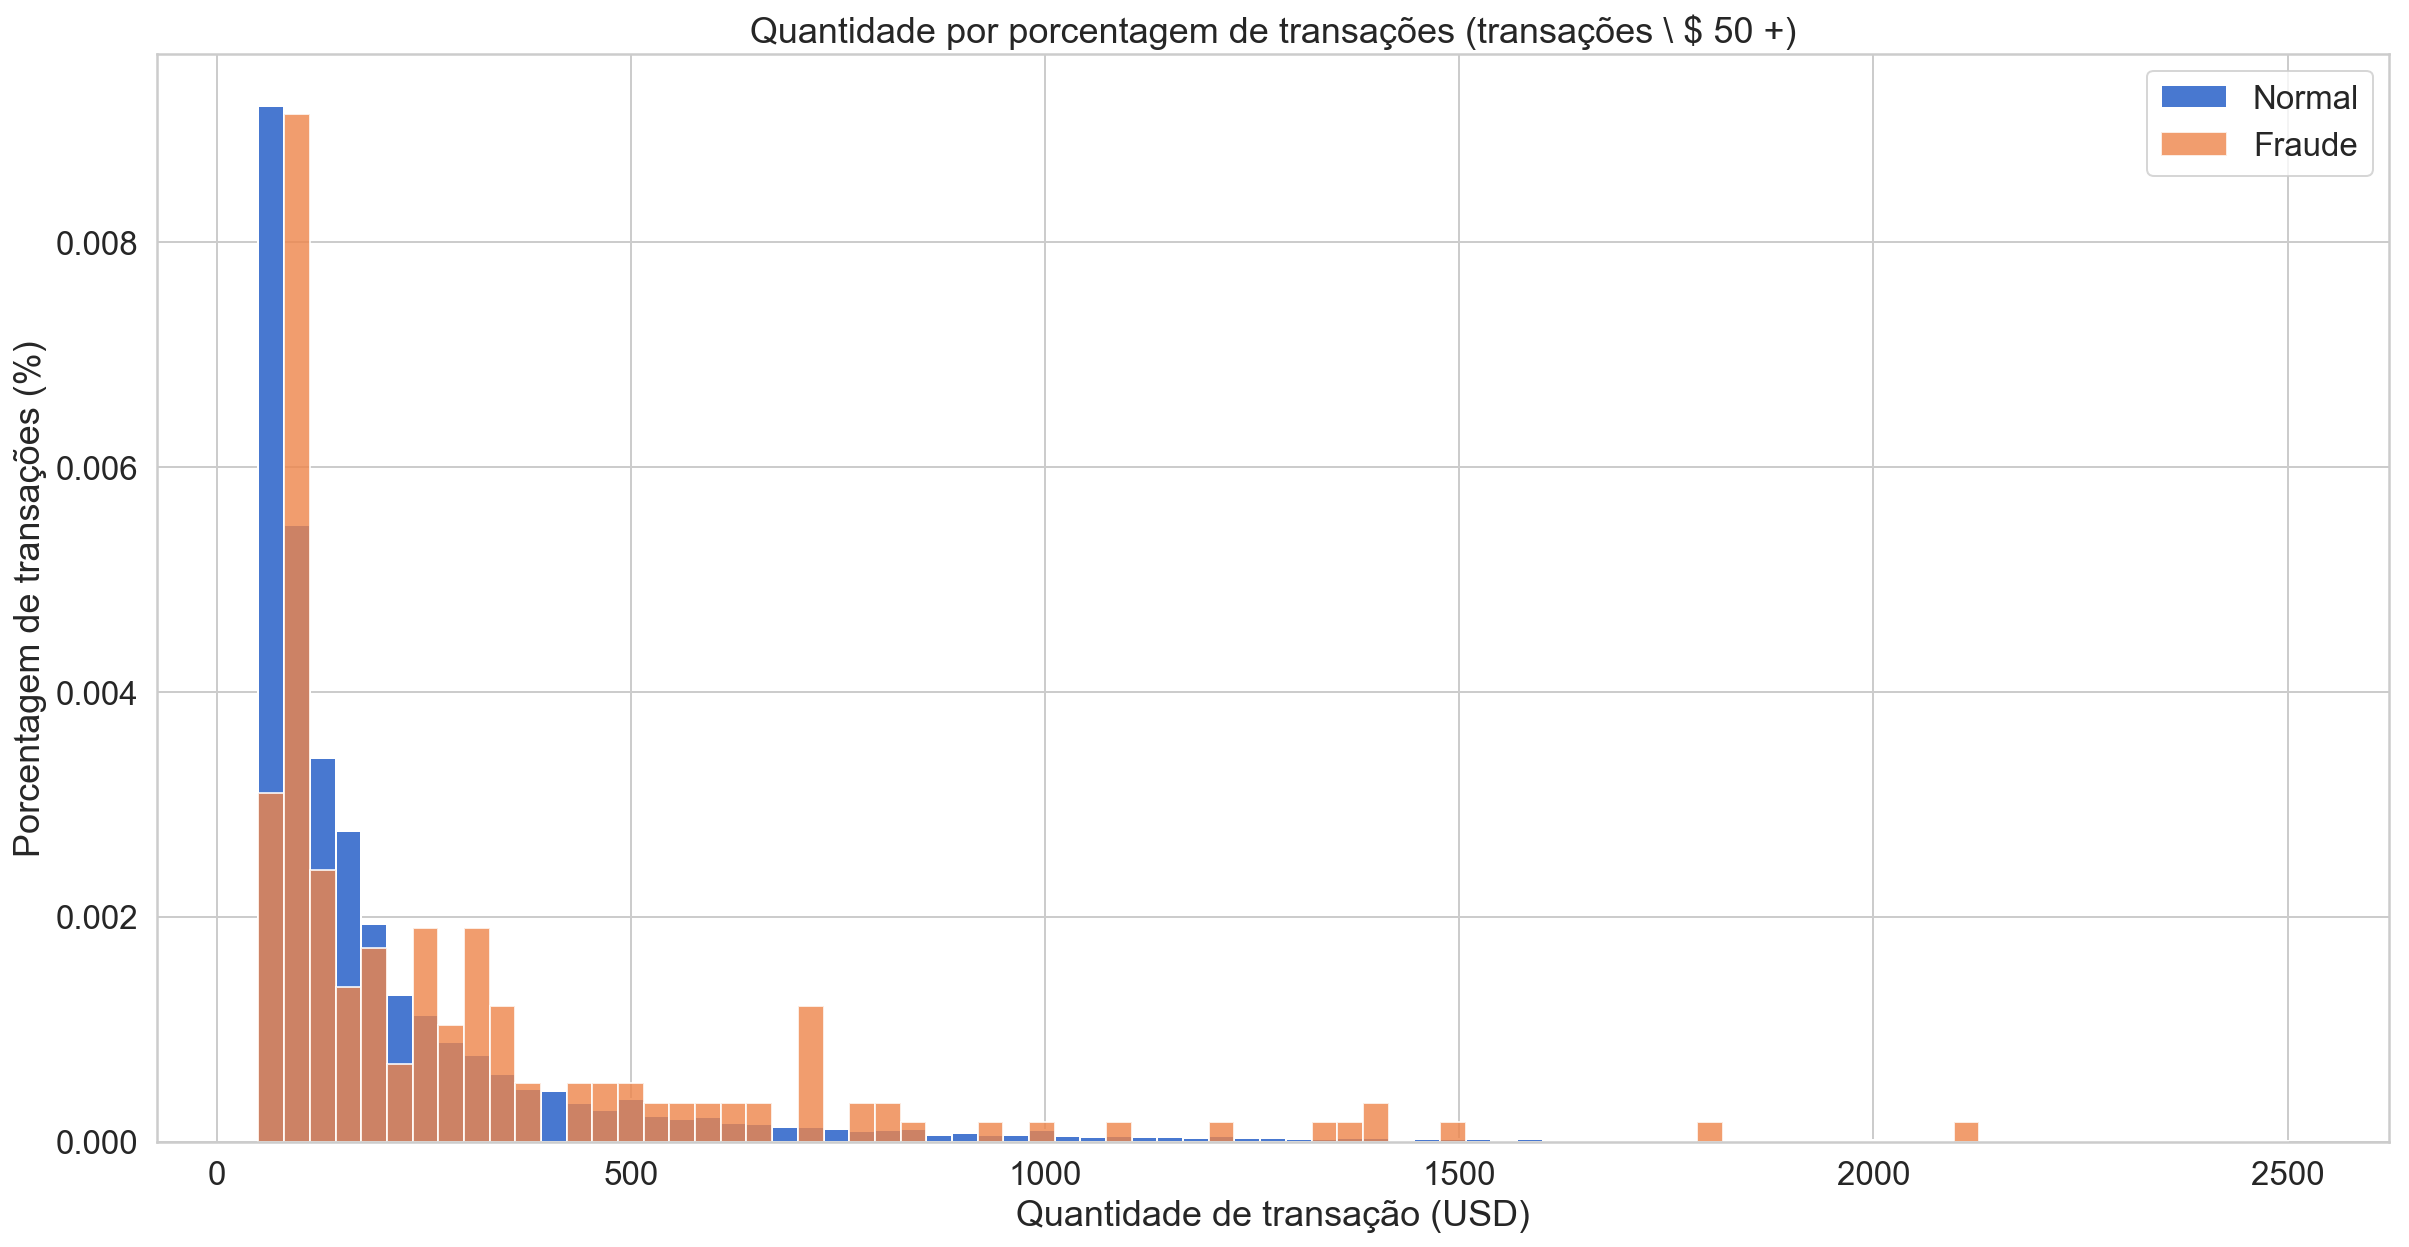

In [112]:
# Plotar a porcentagem de transações para cada valor> = tha $ 50
bins = np.linspace(50, 2500, 80)
plt.hist(normal['Amount'], bins, alpha=1, density=True, label='Normal')
plt.hist(fraud['Amount'], bins, alpha=0.8, density=True, label='Fraude')
plt.legend(loc='upper right')
plt.title("Quantidade por porcentagem de transações (transações \ $ 50 +)")
plt.xlabel("Quantidade de transação (USD)")
plt.ylabel("Porcentagem de transações (%)");
plt.show()

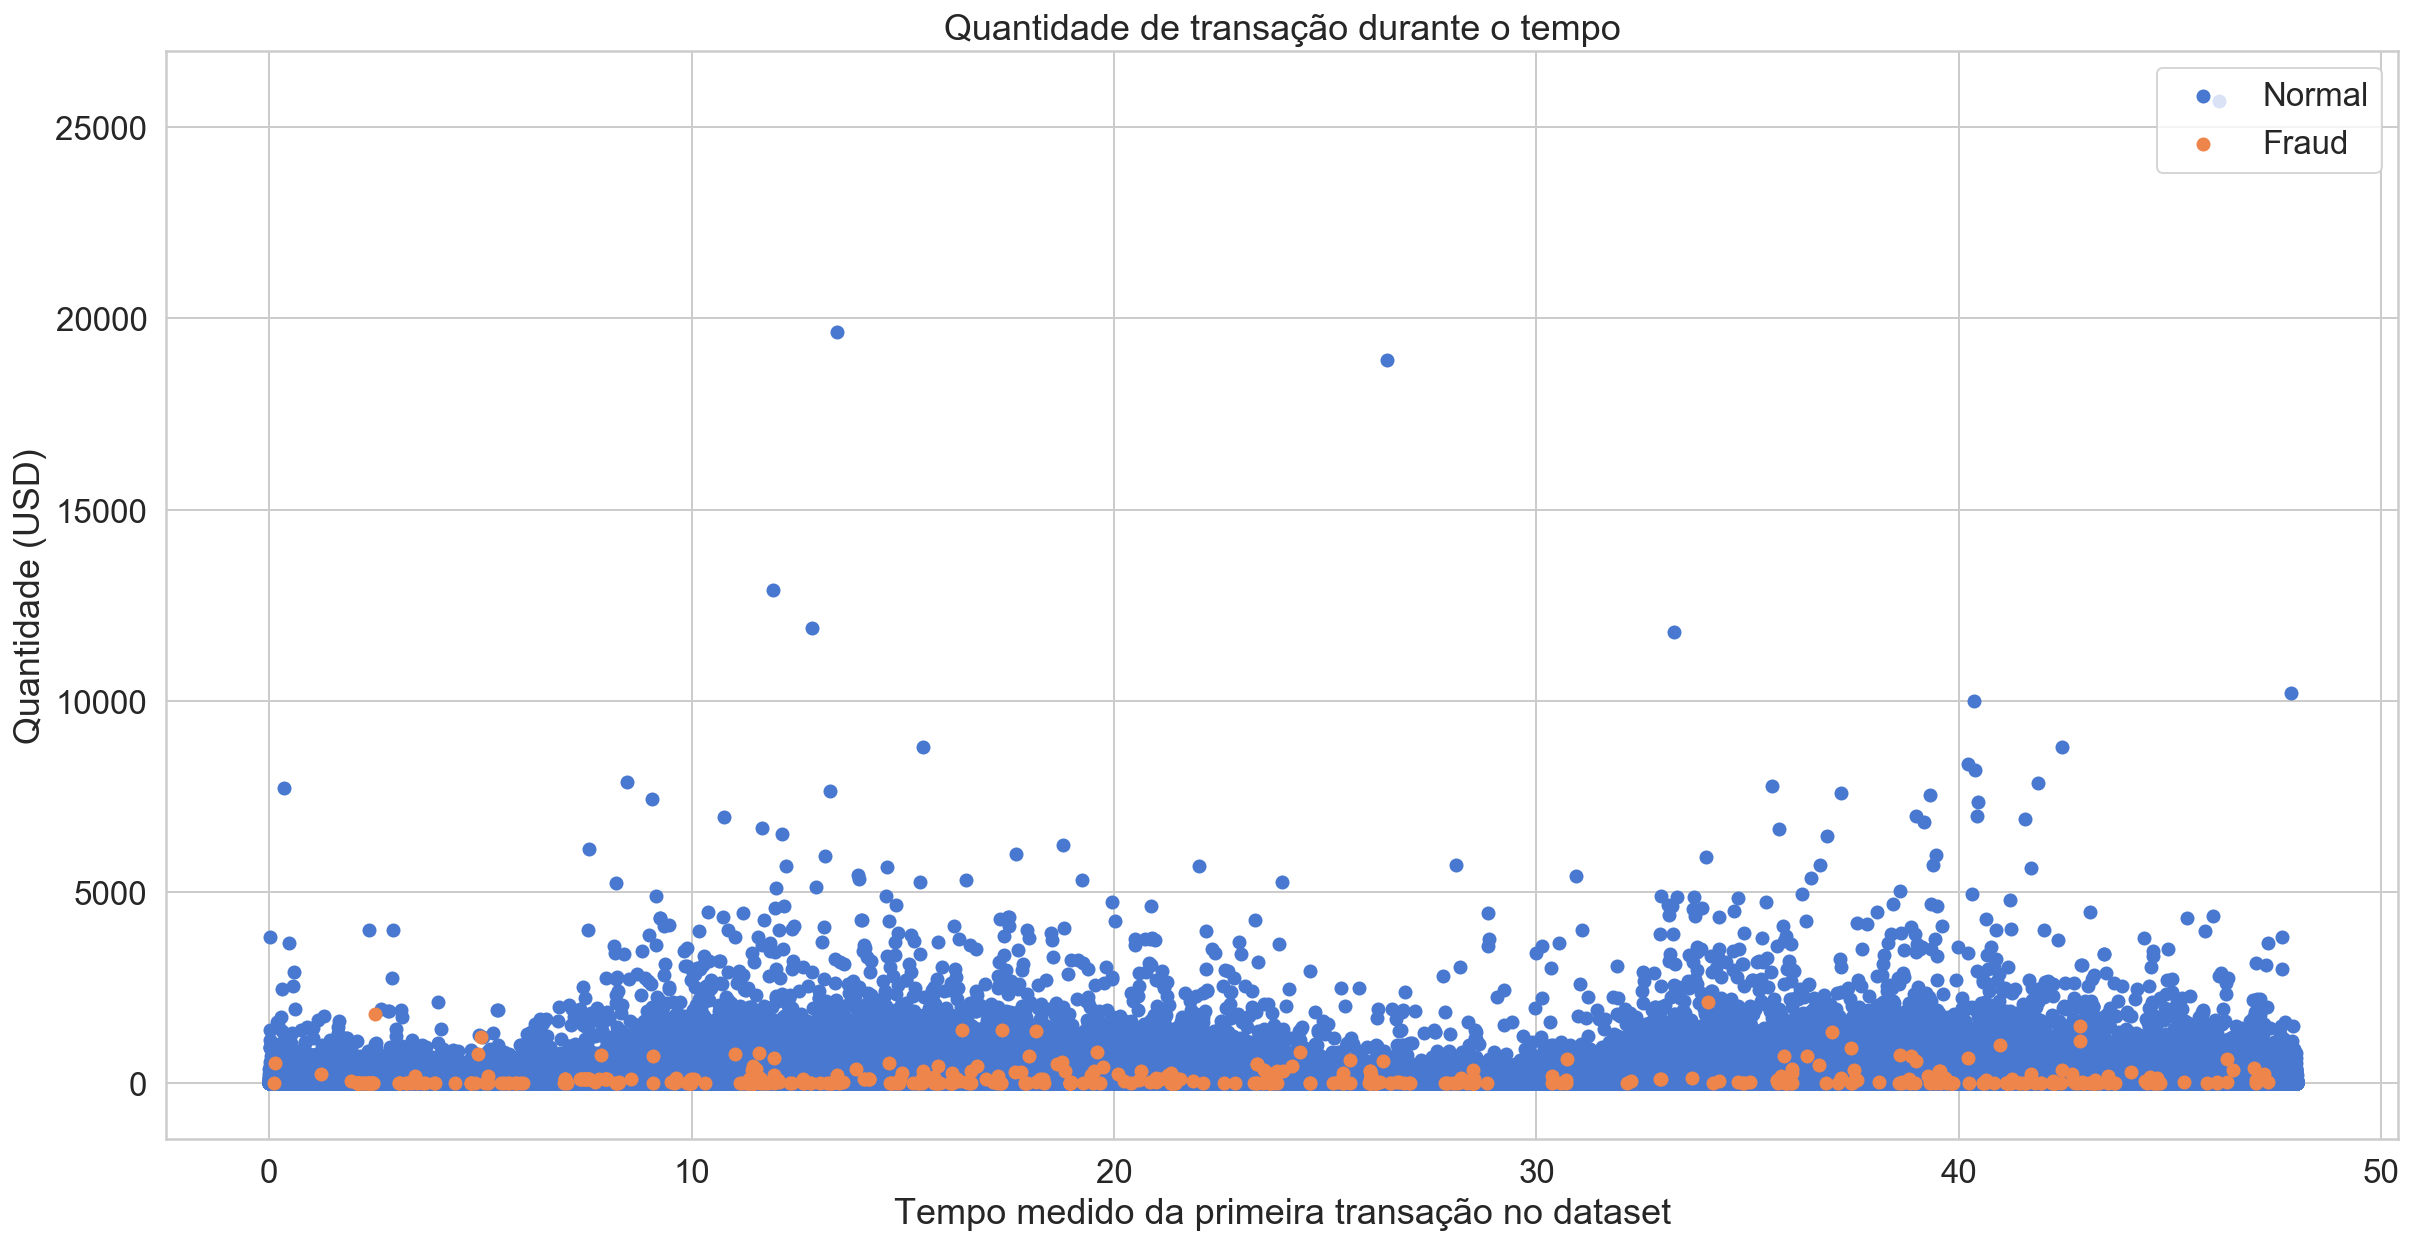

In [113]:
# Traçar a quantidade de transações w.r.t. Tempo
plt.scatter((normal['Time']/(3600)), normal['Amount'], alpha=1, label='Normal')
plt.scatter((fraud['Time']/(3600)), fraud['Amount'], alpha=1, label='Fraud')
plt.title("Quantidade de transação durante o tempo")
plt.xlabel("Tempo medido da primeira transação no dataset")
plt.ylabel('Quantidade (USD)')
plt.legend(loc='upper right')
plt.show()

Observe que o Tempo representa a quantidade de tempo decorrido desde a primeira transação. Parece que o momento da transação não importa e não é tão representativa para acontecer uma fraude. Por isso, é melhor eliminar esse recurso do conjunto de dados. Vamos remover a coluna Tempo e usar o StandardScaler do Scikit no Valor.

In [114]:
# Traçamos a forma do dataset "limpo"
data = df.drop(['Time'], axis=1) 
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.shape

(284807, 30)

Plotamos a distribuição de densidade de cada característica 

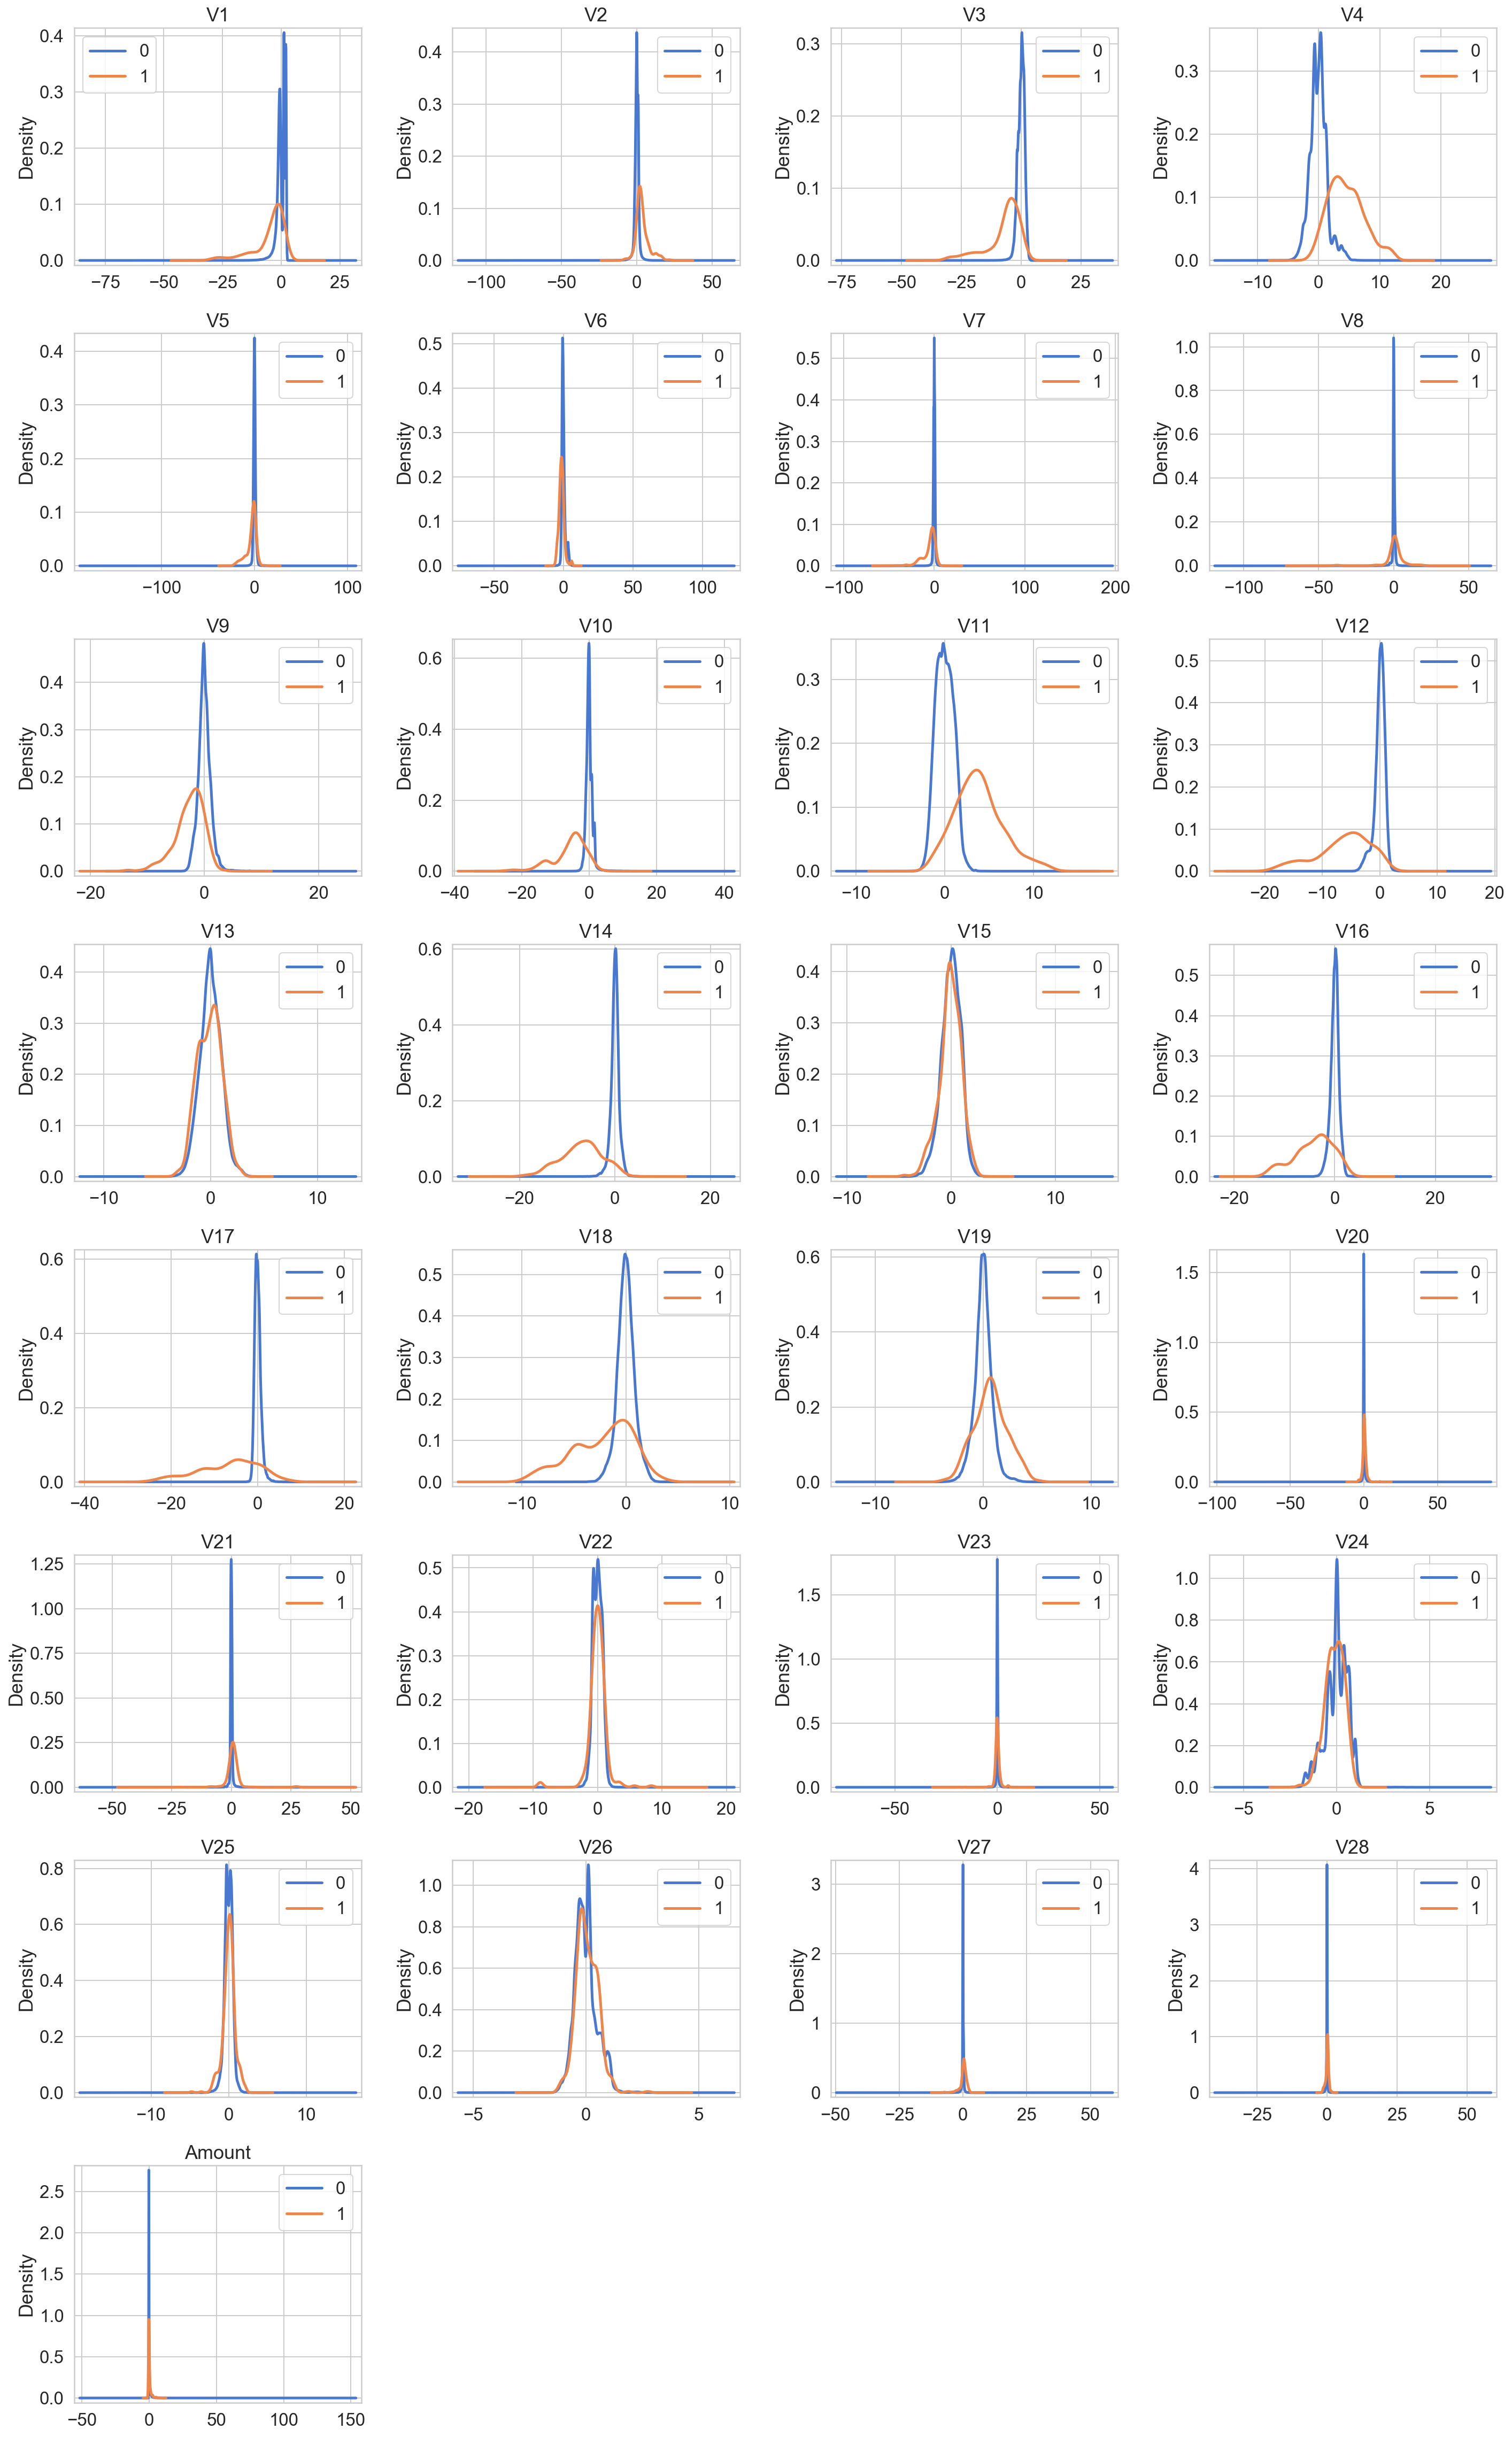

In [115]:
# Scatter subplots
plt.figure(figsize=(20,32))
for plot, feat in enumerate(data.columns[:-1]):
    plt.subplot(8, 4, (plot+1))
    title = str(feat)
    
    # Normalização para visualizar as diferenças nas distribuições
    temp_df = pd.concat([data[feat], data['Class']], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=1, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

A partir do gráfico acima, podemos selecionar os recursos mais importantes e relevantes.

In [116]:
data = data.drop(['V13', 'V15', 'V22', 'V23', 'V26', 'Amount'], axis=1) 
data.shape

(284807, 24)

# Autoencoder
Agora nós dividimos os dados em conjuntos de treinamento e testes. Nós vamos reservar 20% dos nossos dados para testes e 80% para treinamento.

In [117]:
# Dividi o conjunto de dados em treinamento e teste
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 23)

In [118]:
# We use a subset of training for validation
X_train, X_val = train_test_split(X_train, test_size = 0.1, random_state=RANDOM_SEED)
X_train.shape

(204705, 23)

O Autoencoder que vamos desenvolver tem 4 camadas. As duas primeiras camadas codificam os dados com 14 e 7 neurônios respectivamente, enquanto os outros dois começam a reconstruir a entrada:

In [119]:
input_dim = X_train.shape[1]
encoding_dim = 28
learning_rate = 0.001

# Construiremos o autoencoder com 6 camadas. Durante a fase de codificação, mapeamos a entrada em um espaço maior,
# Com o deconding iremos reconstruir o vetor original

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(int(encoding_dim * 2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim * 2), activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)
model = Model(inputs=input_layer, outputs=decoder)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 28)                672       
_________________________________________________________________
dense_12 (Dense)             (None, 56)                1624      
_________________________________________________________________
dense_13 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_14 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_15 (Dense)             (None, 23)                667       
Total params: 7,751
Trainable params: 7,751
Non-trainable params: 0
_________________________________________________________________


In [120]:
nb_epoch = 100
batch_size = 128
model.compile(optimizer='adam',  loss='mean_squared_error',  metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

# treinando o autoencoder
tensorboard = TensorBoard(histogram_freq=0, write_graph=True, write_images=True)
history = model.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                    validation_data=(X_val, X_val), verbose=1, callbacks=[checkpointer, tensorboard]).history

Train on 204705 samples, validate on 22746 samples
Epoch 1/100
204705/204705 [==============================] - 6s 27us/step - loss: 0.9241 - acc: 0.7135 - val_loss: 0.7988 - val_acc: 0.8086
Epoch 2/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.7257 - acc: 0.8233 - val_loss: 0.7645 - val_acc: 0.8475
Epoch 3/100
204705/204705 [==============================] - 3s 15us/step - loss: 0.7036 - acc: 0.8531 - val_loss: 0.7526 - val_acc: 0.8462
Epoch 4/100
204705/204705 [==============================] - 3s 13us/step - loss: 0.6946 - acc: 0.8645 - val_loss: 0.7500 - val_acc: 0.8591
Epoch 5/100
204705/204705 [==============================] - 3s 16us/step - loss: 0.6867 - acc: 0.8830 - val_loss: 0.7338 - val_acc: 0.8715
Epoch 6/100
204705/204705 [==============================] - 5s 22us/step - loss: 0.6837 - acc: 0.8851 - val_loss: 0.7338 - val_acc: 0.8641
Epoch 7/100
204705/204705 [==============================] - 3s 14us/step - loss: 0.6813 - acc: 0.8897 - val_

Epoch 59/100
204705/204705 [==============================] - 4s 18us/step - loss: 0.6643 - acc: 0.9009 - val_loss: 0.7034 - val_acc: 0.9098
Epoch 60/100
204705/204705 [==============================] - 3s 16us/step - loss: 0.6663 - acc: 0.8956 - val_loss: 0.7173 - val_acc: 0.8659
Epoch 61/100
204705/204705 [==============================] - 3s 14us/step - loss: 0.6722 - acc: 0.8873 - val_loss: 0.7075 - val_acc: 0.8918
Epoch 62/100
204705/204705 [==============================] - 3s 13us/step - loss: 0.6650 - acc: 0.8999 - val_loss: 0.7017 - val_acc: 0.9152
Epoch 63/100
204705/204705 [==============================] - 2s 12us/step - loss: 0.6664 - acc: 0.8960 - val_loss: 0.7103 - val_acc: 0.9012
Epoch 64/100
204705/204705 [==============================] - 3s 15us/step - loss: 0.6646 - acc: 0.8982 - val_loss: 0.7043 - val_acc: 0.8980
Epoch 65/100
204705/204705 [==============================] - 2s 11us/step - loss: 0.6679 - acc: 0.8940 - val_loss: 0.7021 - val_acc: 0.9125
Epoch 66/100


# Avaliação
Vamos começar a avaliar as performances. Primeiro de tudo, plotamos a função de perda para verificar se o modelo aprendeu alguma coisa.

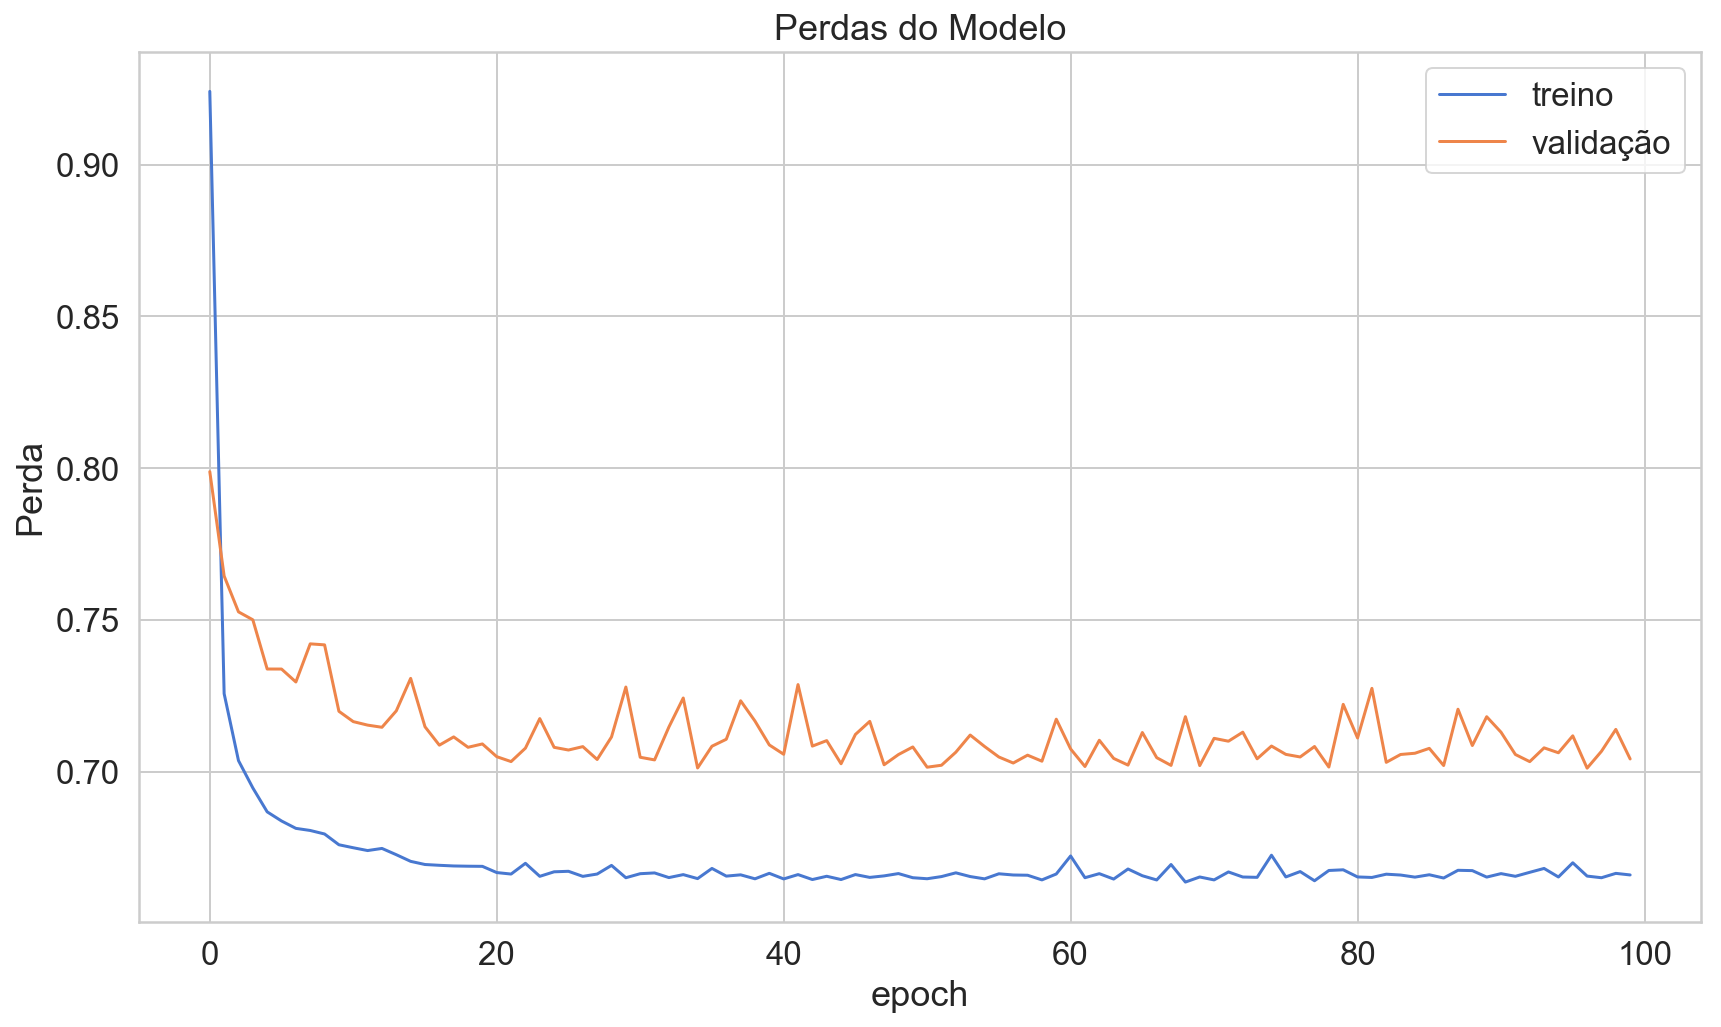

In [121]:
# Plot a função de perda
plt.figure(figsize=(14,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Perdas do Modelo')
plt.ylabel('Perda')
plt.xlabel('epoch')
plt.legend(['treino', 'validação'], loc='upper right');

O erro experimental em nossos dados de treinamento e teste parece convergir. Vamos analisar a distribuição de erros:

In [122]:
# Vamos prever novos dados para avaliar o modelo
predictions = model.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.693891,0.001720
std,3.978991,0.041443
min,0.016158,0.000000
25%,0.174171,0.000000
50%,0.310614,0.000000
75%,0.553210,0.000000
max,355.132986,1.000000


Podemos usar curvas ROC para medir o desempenho da rede neural:

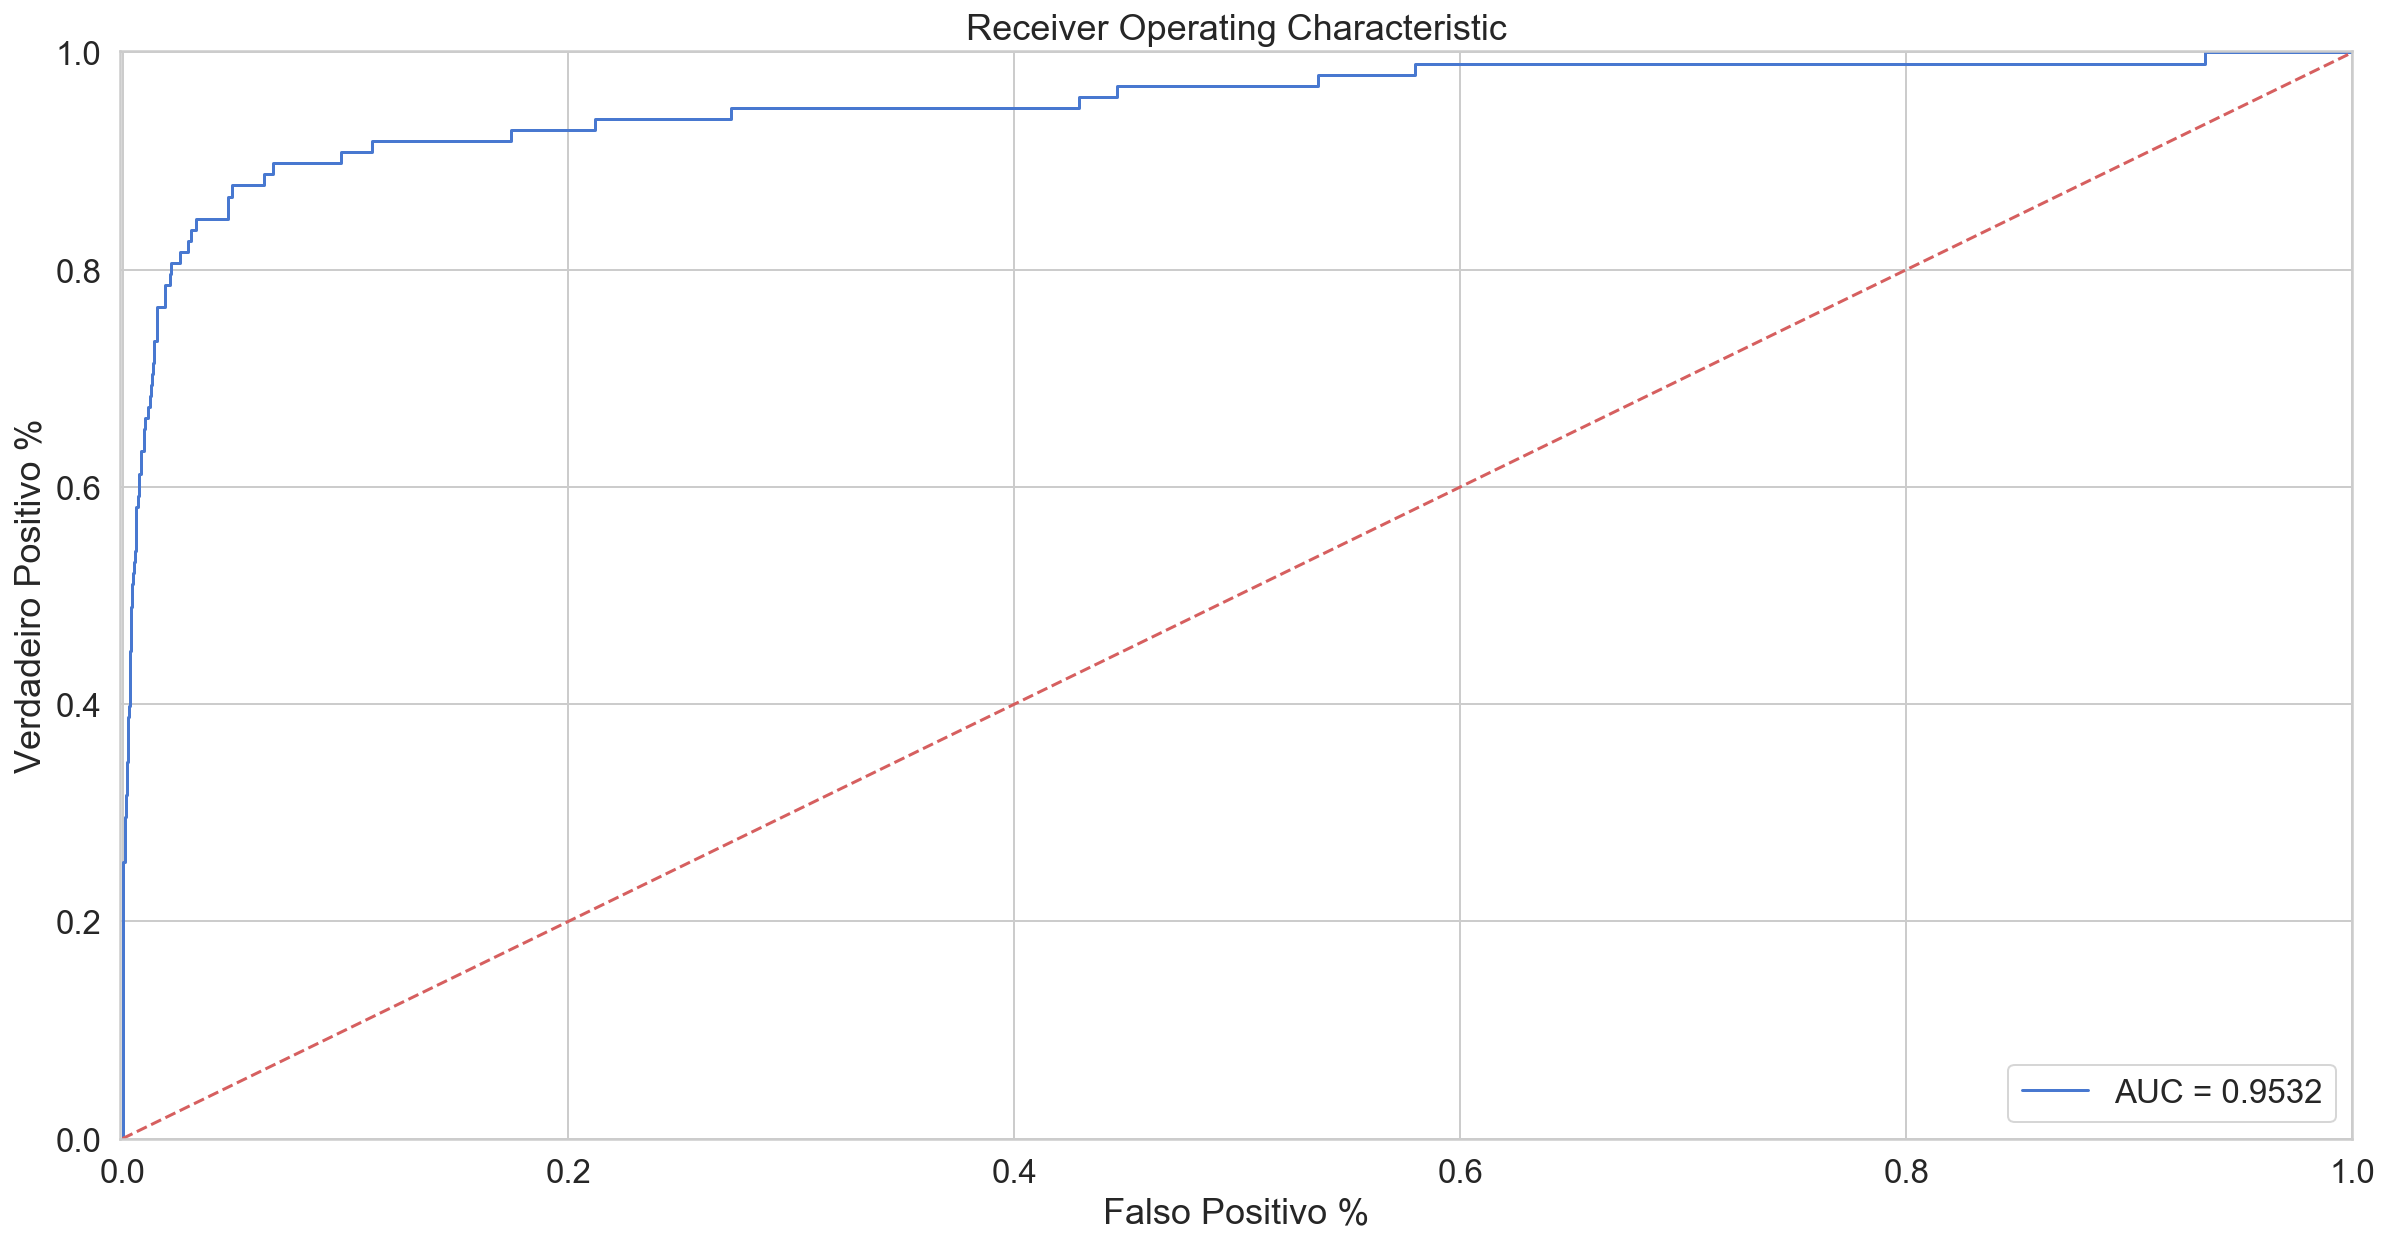

In [123]:
# Plot a curva ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Verdadeiro Positivo %')
plt.xlabel('Falso Positivo %')
plt.show();

Lembramos que o recall mede os itens relevantes que foram selecionados. Já a precisão mede quantos itens selecionados são relevantes. Nós gostaríamos de obter valores altos de ambos.



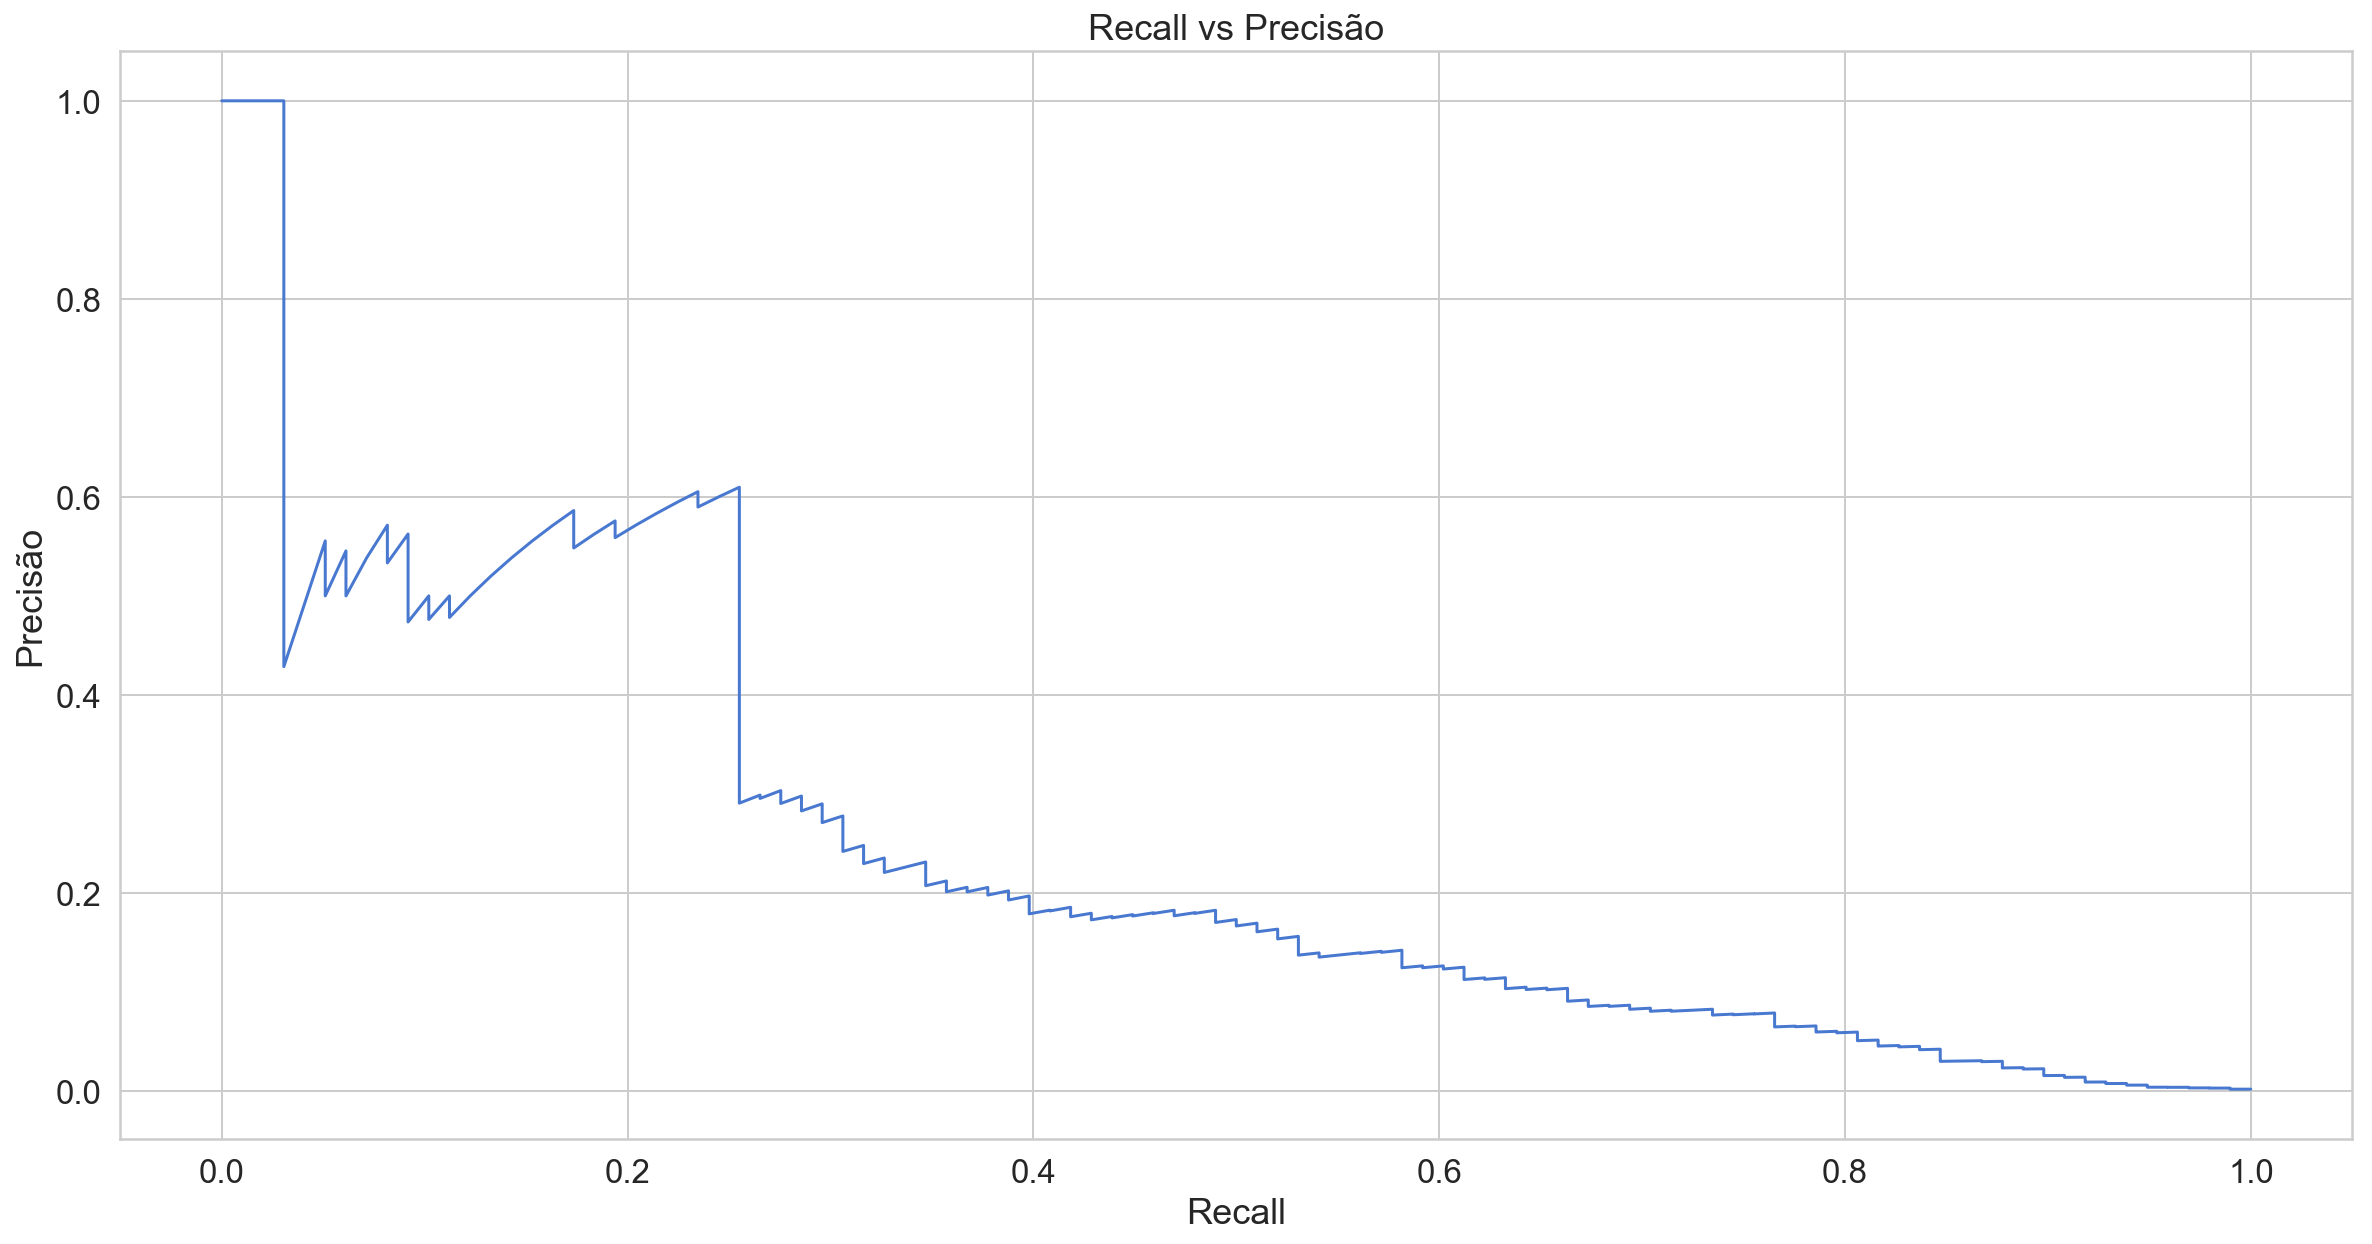

In [124]:
# Plotar curva precisão e recall 
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Curva Precisão-Recall')
plt.title('Recall vs Precisão')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

A alta precisão está relacionada a uma baixa taxa de falsos positivos, já o alta recall está relacionada a uma baixa taxa de falsos negativos. As pontuações mais altas para ambos mostram que o classificador está retornando resultados precisos com a maioria dos resultados corretos.

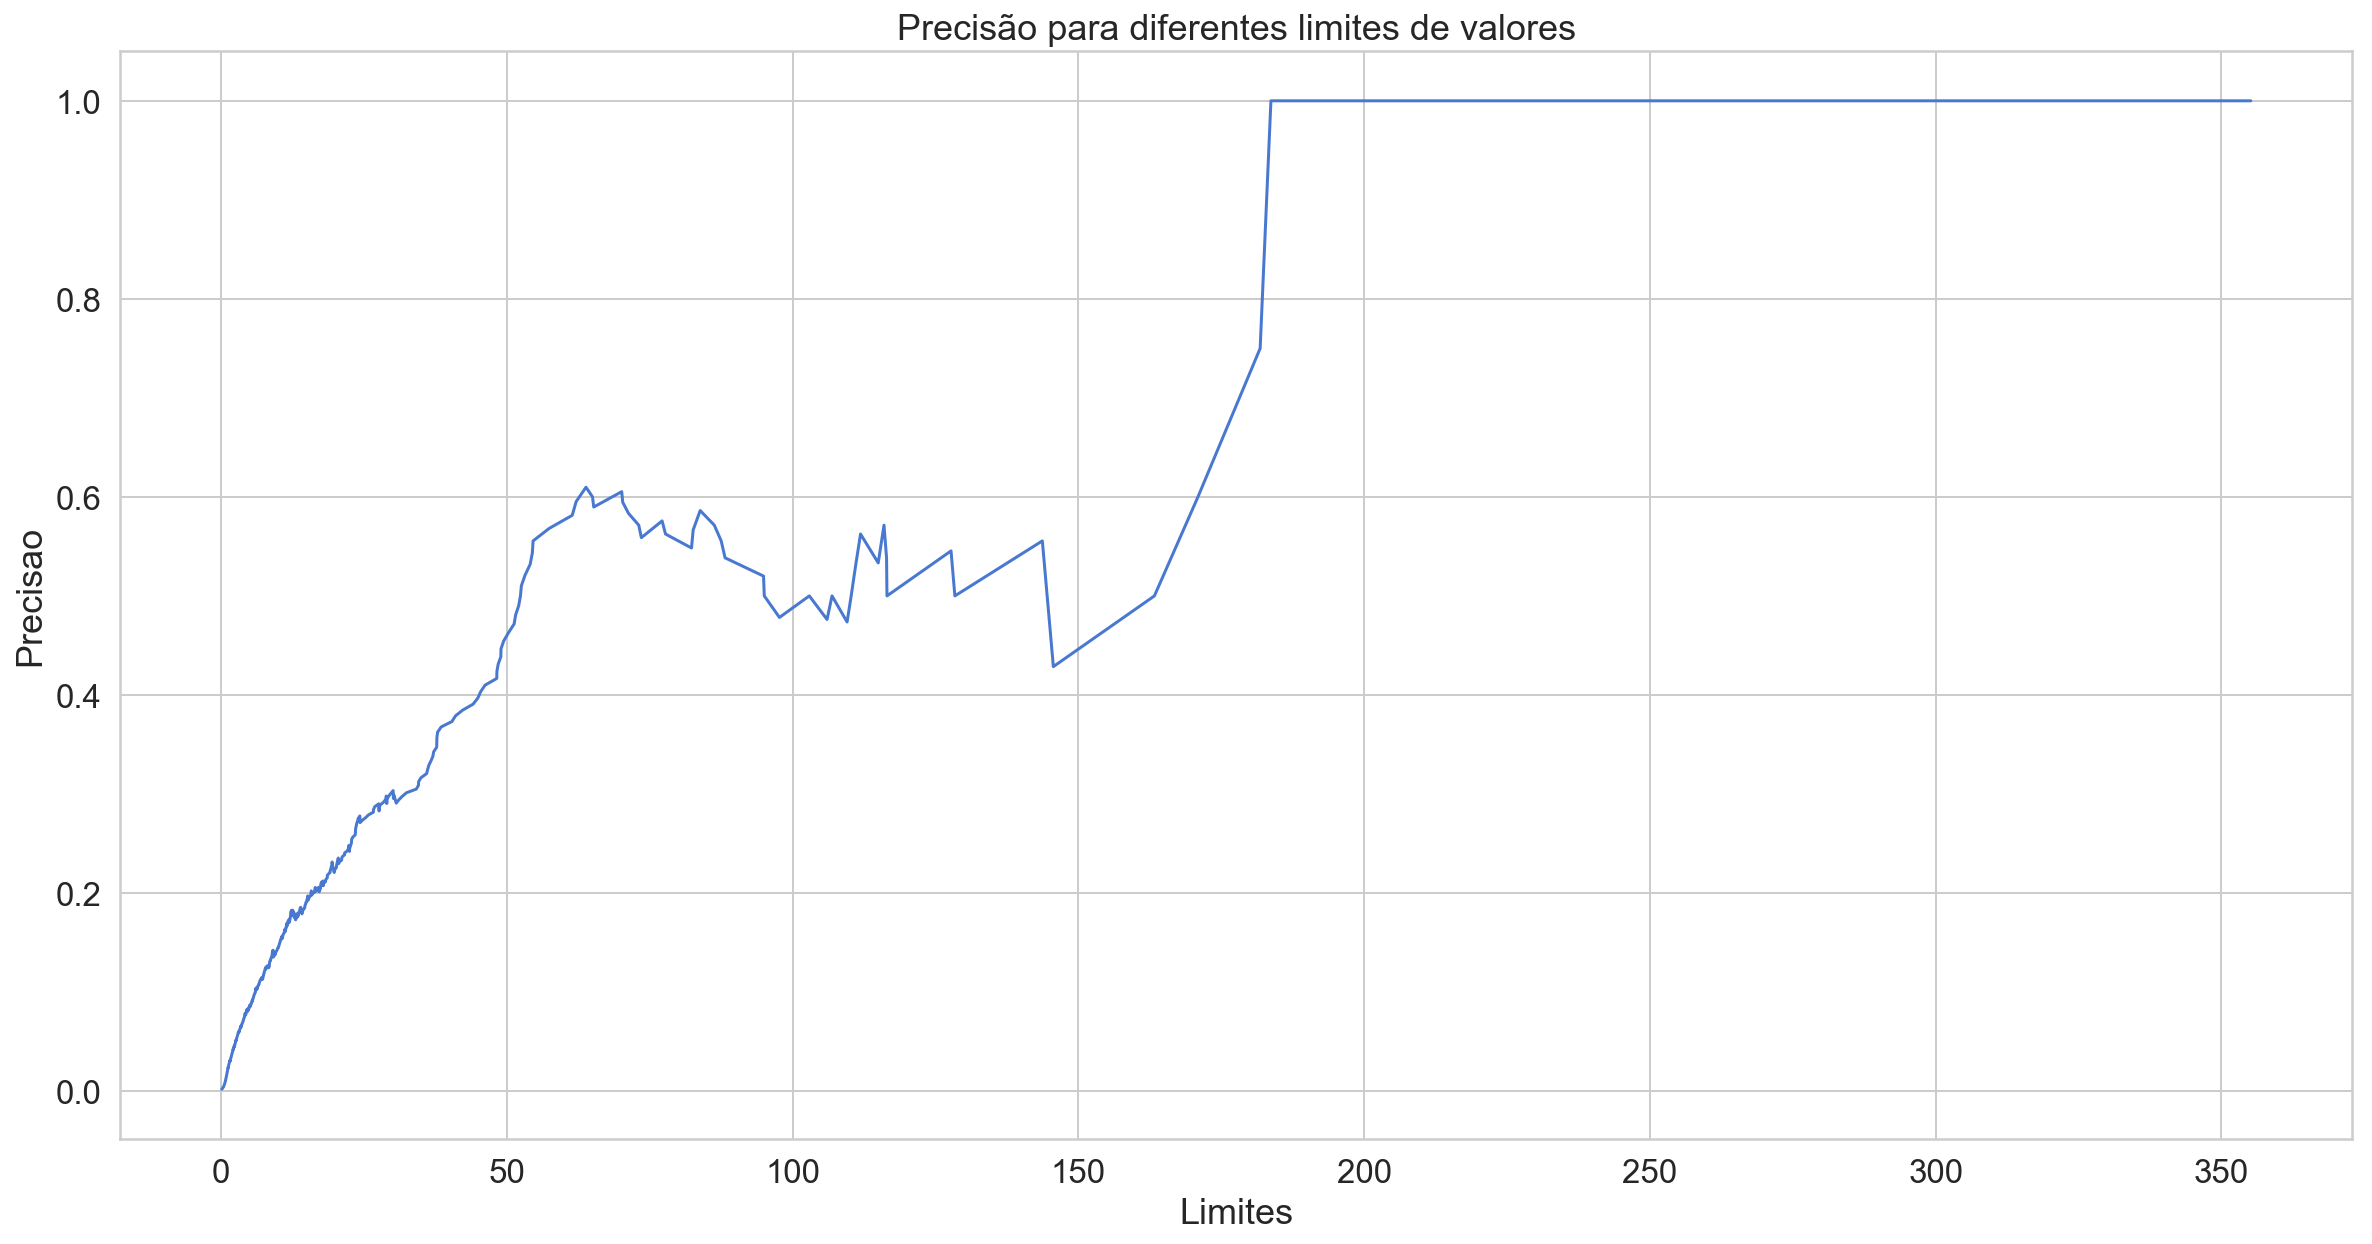

In [125]:
# Plot a  Precisão para diferentes limites
plt.plot(th, precision[1:], 'b', label='Limites-Curva de Precisao')
plt.title('Precisão para diferentes limites de valores')
plt.xlabel('Limites')
plt.ylabel('Precisao')
plt.show()

Podemos ver que, à medida que o erro de experimental aumenta, nossa precisão aumenta também. Vamos dar uma olhada no recall:

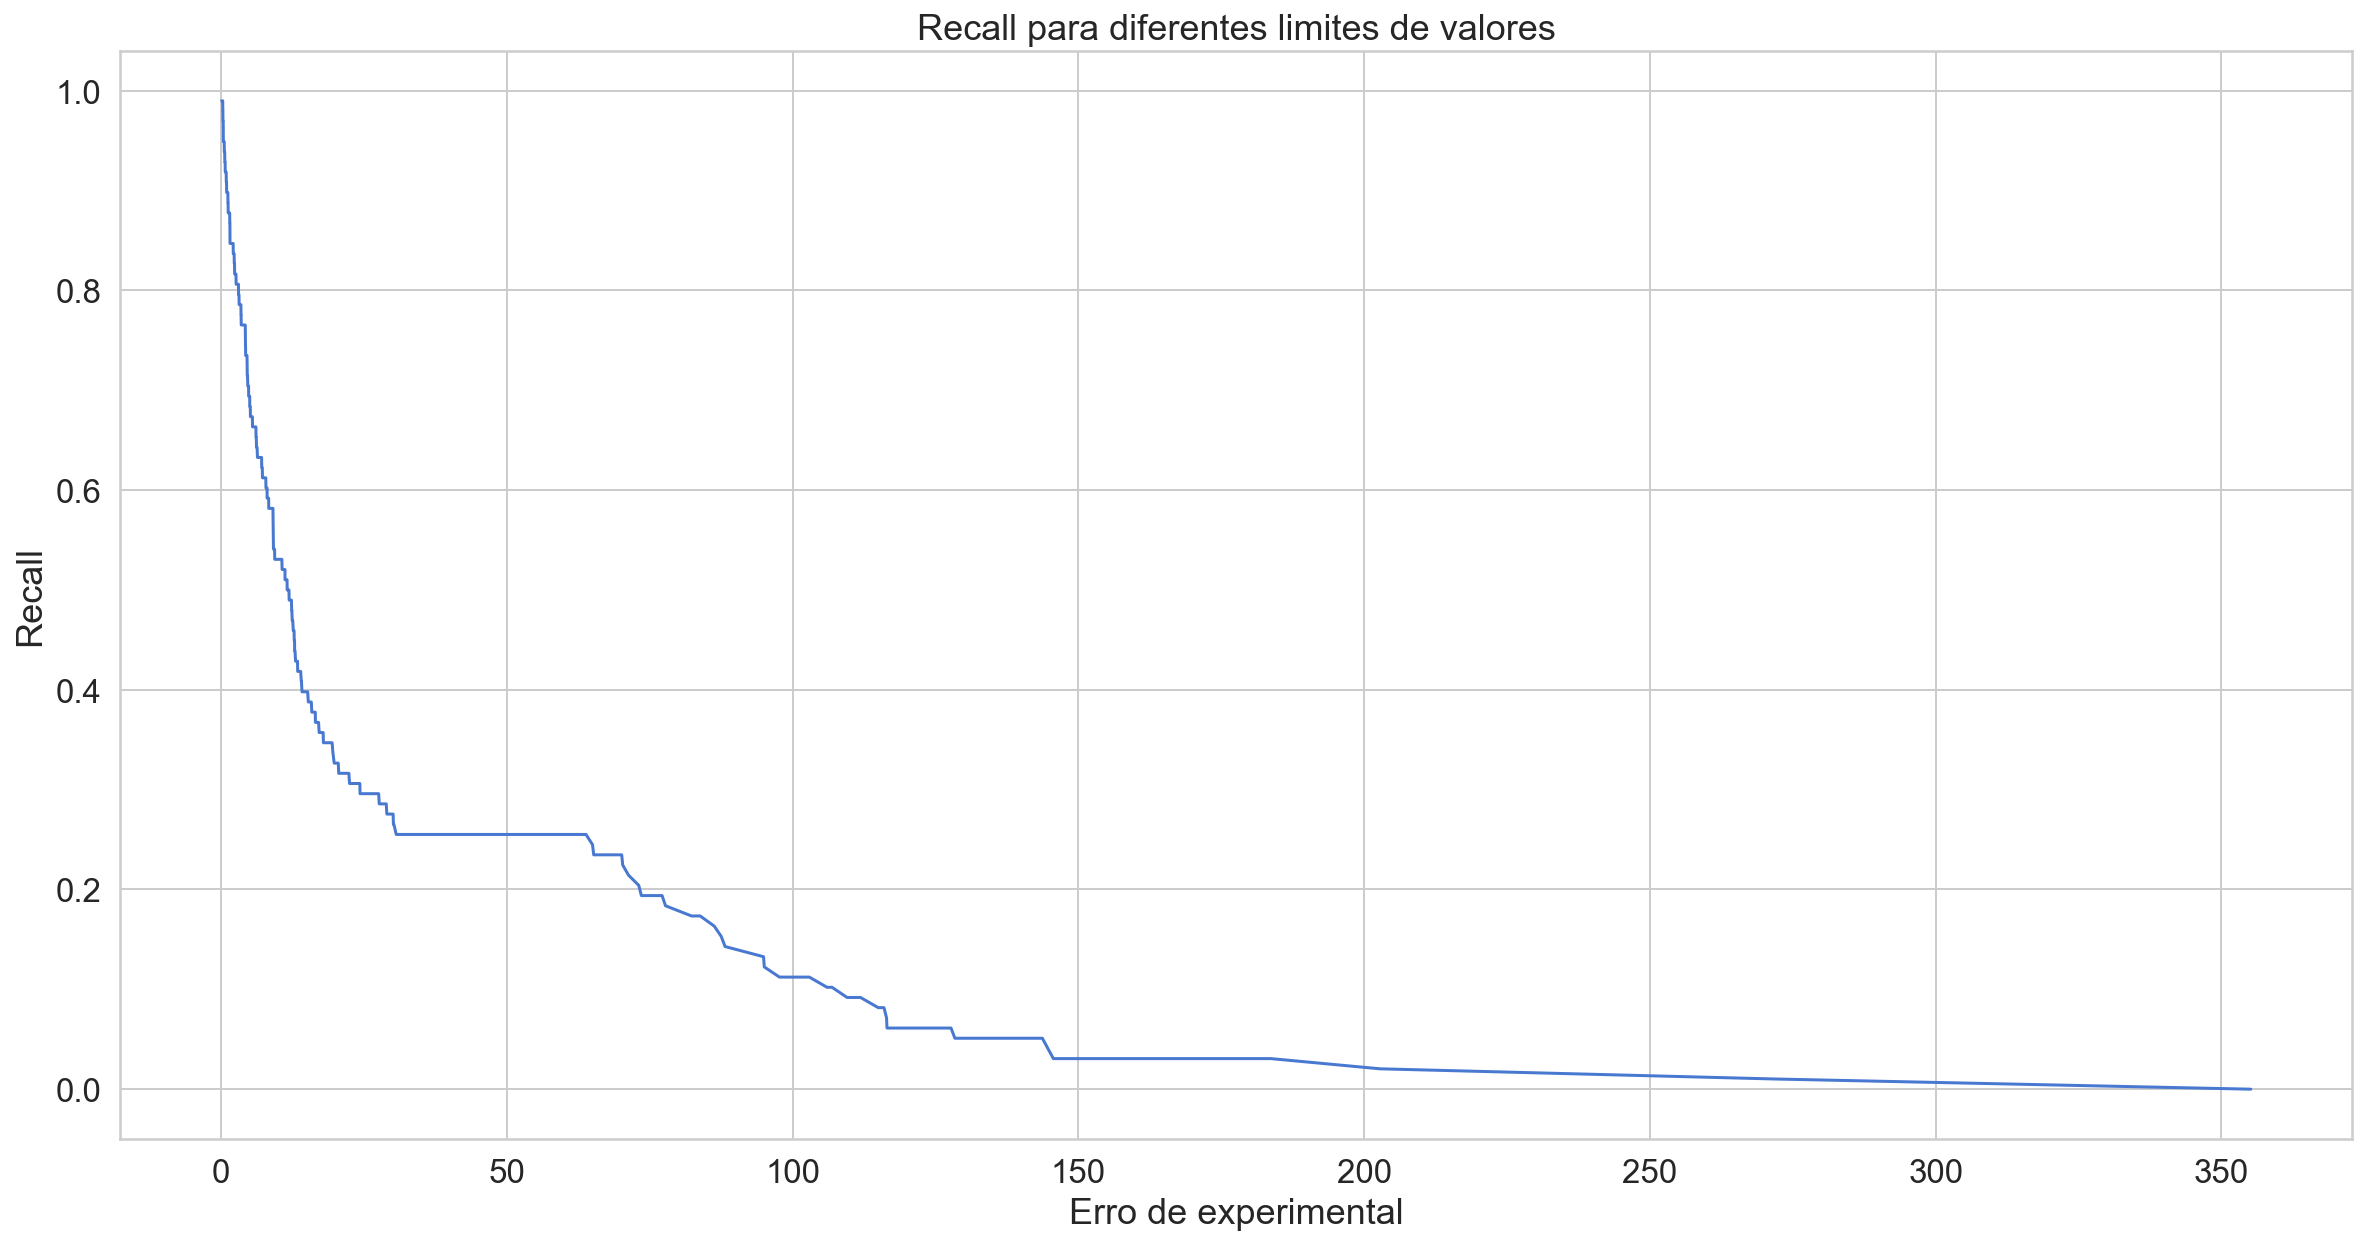

In [126]:
# Plot recall para diferentes limites
plt.plot(th, recall[1:], 'b', label='Curva Limites-Recall')
plt.title('Recall para diferentes limites de valores')
plt.xlabel('Erro de experimental')
plt.ylabel('Recall')
plt.show()

Nosso modelo não sabe como prever novos valores. Para prever se uma nova transação é normal ou fraudulenta, calcularemos o erro experimental dos próprios dados da transação. Se o erro for maior do que um limite predefinido, nós o marcaremos como uma fraude (já que nosso modelo deve ter um erro baixo nas transações normais)! Vamos dar uma olhada na matriz de confusão:

In [127]:
# Nós consertamos um threshold (limite).
threshold = 2.2

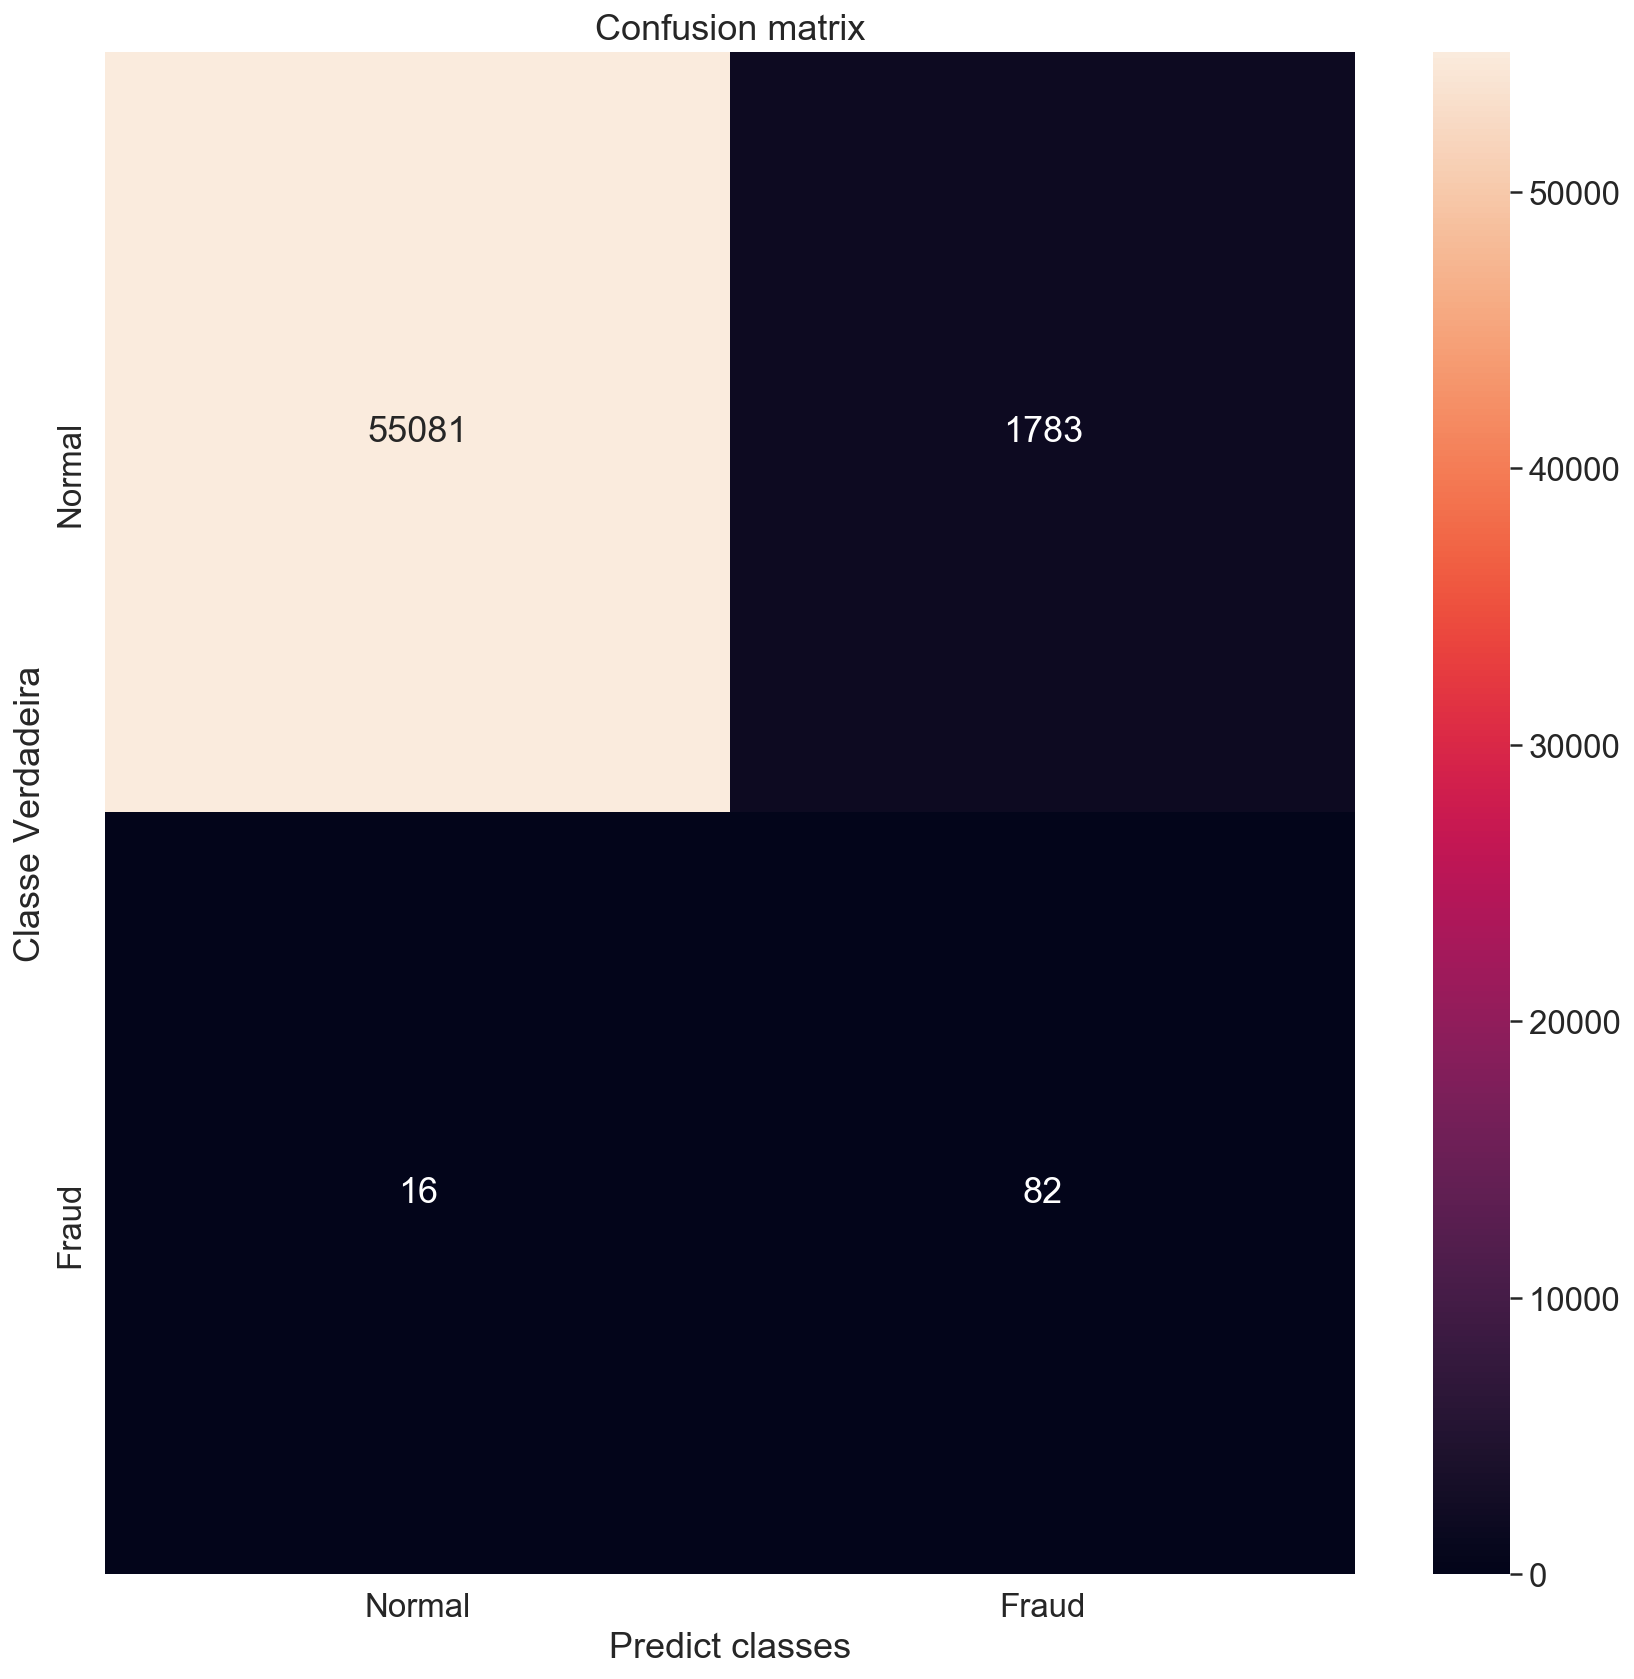

In [128]:
# Vamos verificar a matriz de confusão para o limite fixo
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(14, 14))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Classe Verdadeira')
plt.xlabel('Predict classes')
plt.show()

# Modelo alternativo: RandomForests

Vamos comparar os resultados que obtivemos com um modelo alternativo e (talvez) melhor. Começamos novamente a dividir o conjunto de dados entre o trem e o conjunto de testes.

In [129]:
# Novamente, nos dividimos em conjuntos de treinamento e testes
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train.shape

(227845, 23)

Vamos criar também um conjunto de validação:

In [130]:
# Usamos um subconjunto de treinamento para validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=RANDOM_SEED)

Temos um conjunto de dados fortemente desbalanceado, portanto, podemos tentar superar esse problema usando uma técnica de *soversampling* (Super-amostragem) — SMOTE.

In [131]:
# Iremos balancear os dados utilizando o SMOTE que ira cria observações sintéticas de dados fraudulentos
smote = SMOTE(random_state=RANDOM_SEED, ratio='auto', kind='regular')
X_train_ovsamp, y_train_ovsamp = smote.fit_sample(X_train, y_train)
X_train_ovsamp.shape

(409402, 23)

Agora podemos treinar o classificador Random Forest:

In [132]:
# Treino do modelo 
classifier = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model = classifier.fit(X_train_ovsamp, y_train_ovsamp)

C:\Users\danil\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Avaliação
Mais uma vez, avaliamos o modelo. Primeiramente, vamos verificar se aconteceu overfitted com os dados que imprimem os resultados nos conjuntos de validação e teste.

In [133]:
# Plot os resultados para conjuntos de validação e teste
print('Validation Results')
print(rf_model.score(X_val, y_val))
print(recall_score(y_val, rf_model.predict(X_val)))
print('\nTest Results')
print(rf_model.score(X_test, y_test))
print(recall_score(y_test, rf_model.predict(X_test)))

Validation Results
0.9996927803379416
0.9428571428571428

Test Results
0.9995084442259752
0.8367346938775511


Plote o erro de experimental em cada etapa:

In [134]:
# verifique erros de experimental
mse = np.mean(np.power(np.array(y_test) - rf_model.predict(X_test), 2))
error_df = pd.DataFrame({'erro_experimental': mse, 'classes_verdadeiras': y_test})
error_df.describe()

,erro_experimental,classes_verdadeiras
count,5.696200e+04,56962.000000
mean,4.915558e-04,0.001720
std,4.125425e-16,0.041443
min,4.915558e-04,0.000000
25%,4.915558e-04,0.000000
50%,4.915558e-04,0.000000
75%,4.915558e-04,0.000000
max,4.915558e-04,1.000000


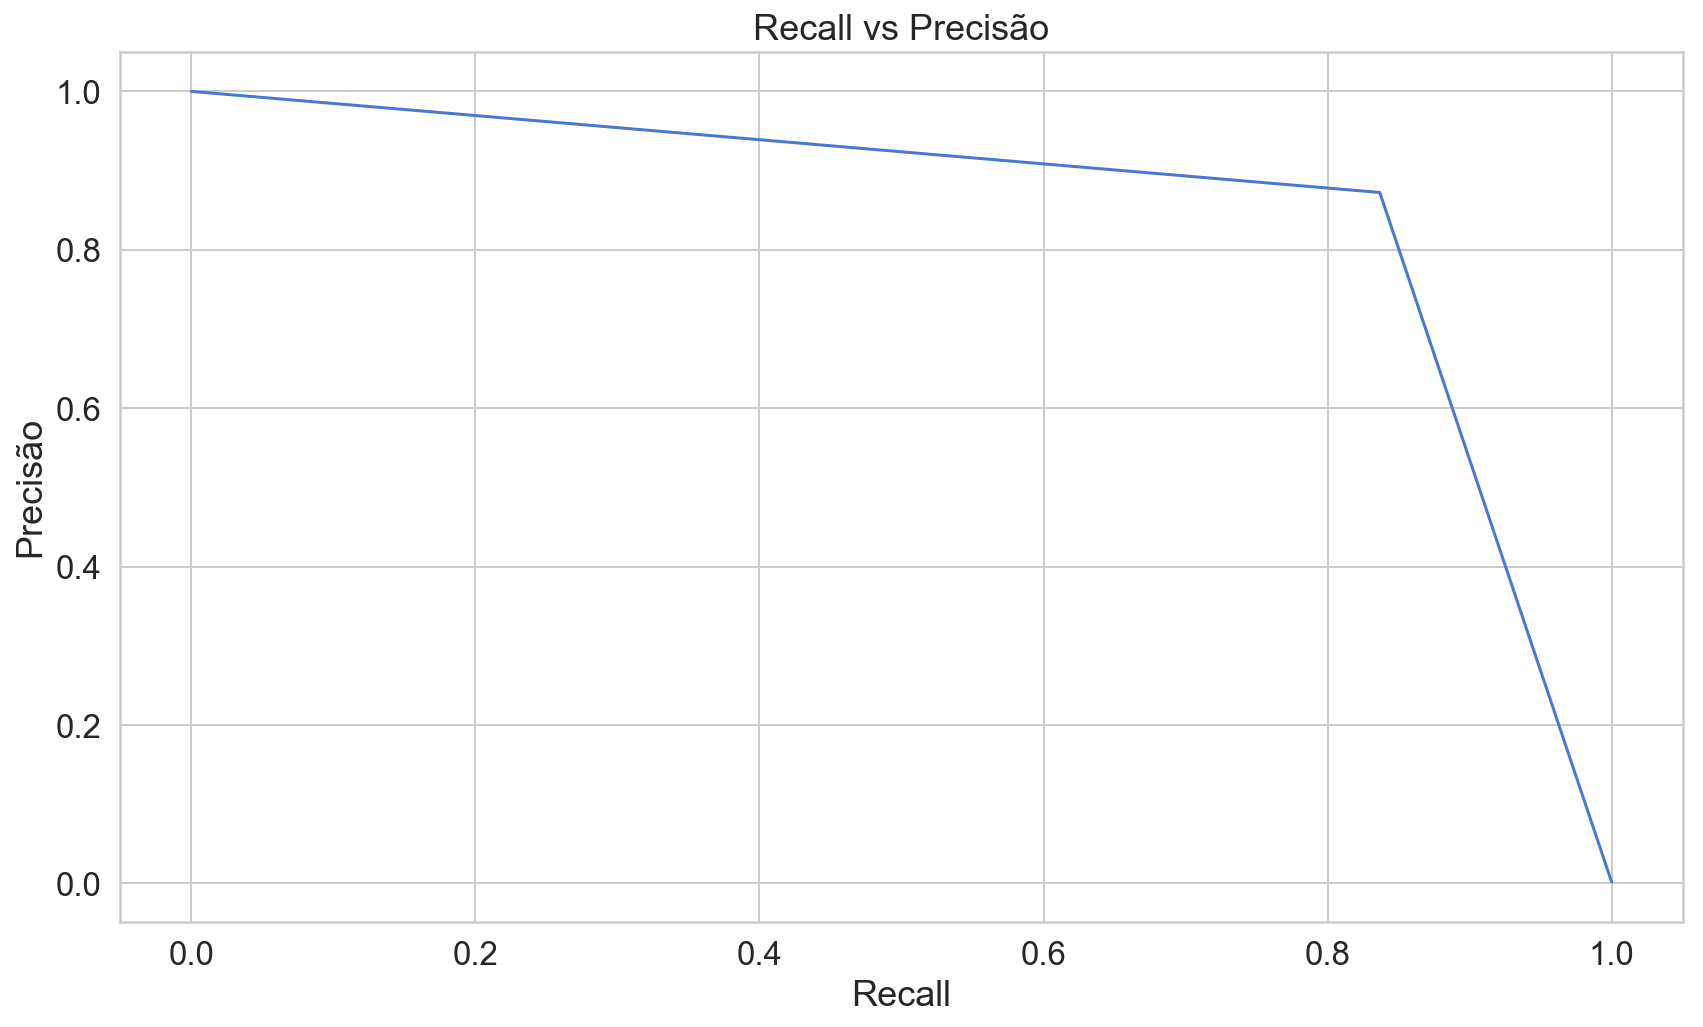

In [135]:
# Plot precisão-recall curva
precision, recall, th = precision_recall_curve(y_test, rf_model.predict(X_test))
plt.figure(figsize=(14,8))
plt.plot(recall, precision, 'b', label='precisão-Recall curva')
plt.title('Recall vs Precisão')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

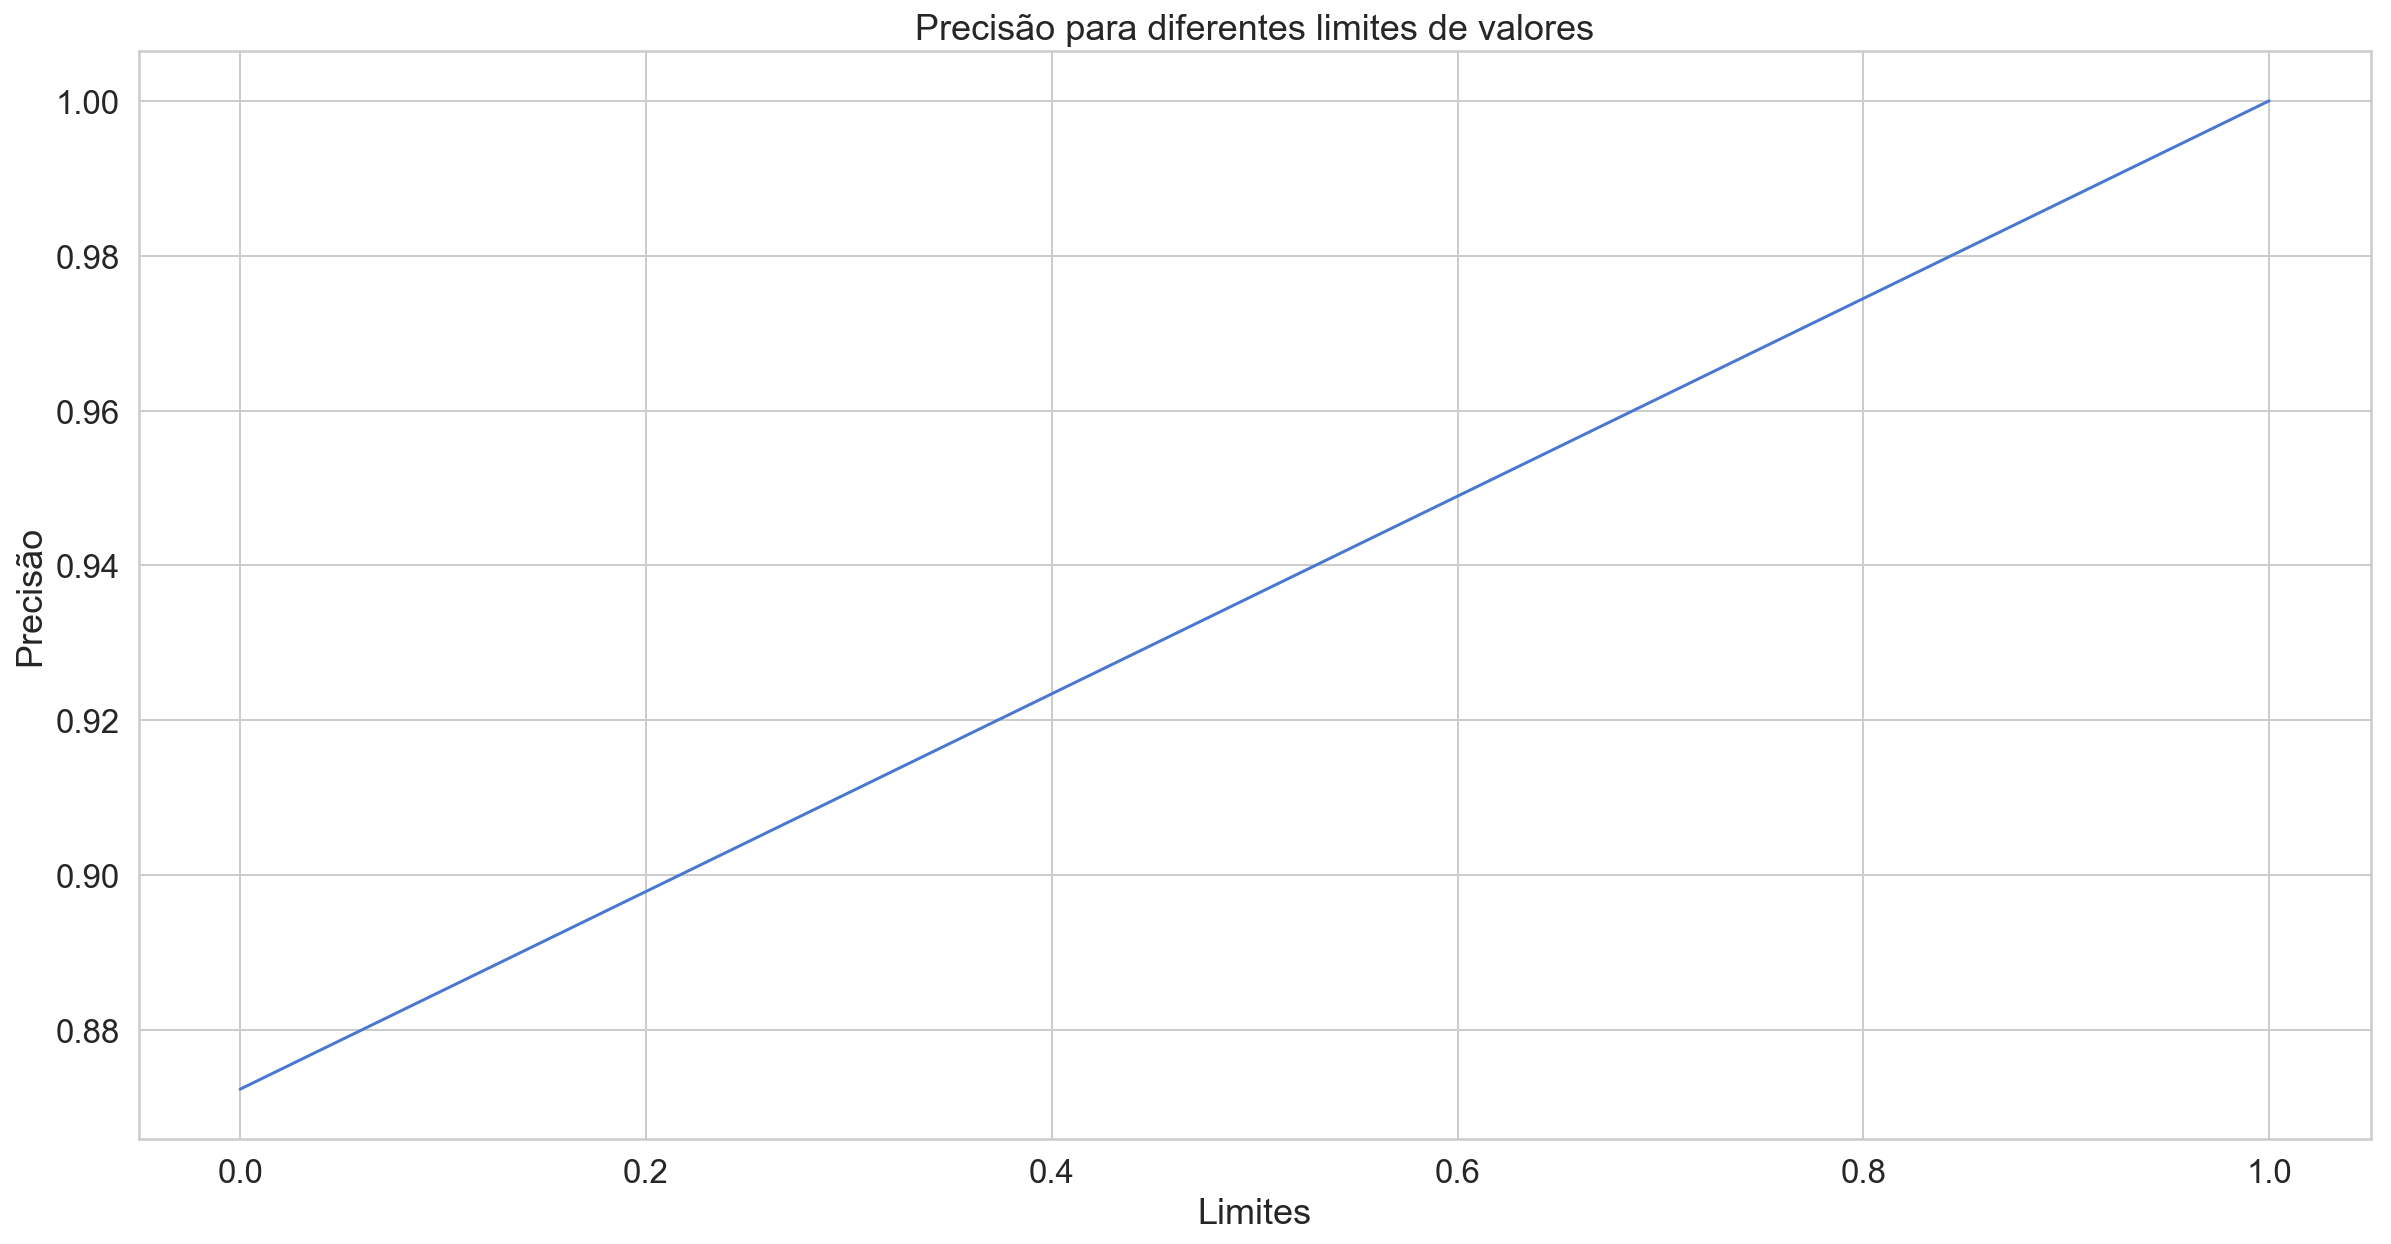

In [136]:
# Plote a precisão para diferentes limites
plt.plot(th, precision[1:], 'b', label='Limites-Precisão curva')
plt.title('Precisão para diferentes limites de valores')
plt.xlabel('Limites')
plt.ylabel('Precisão')
plt.show()

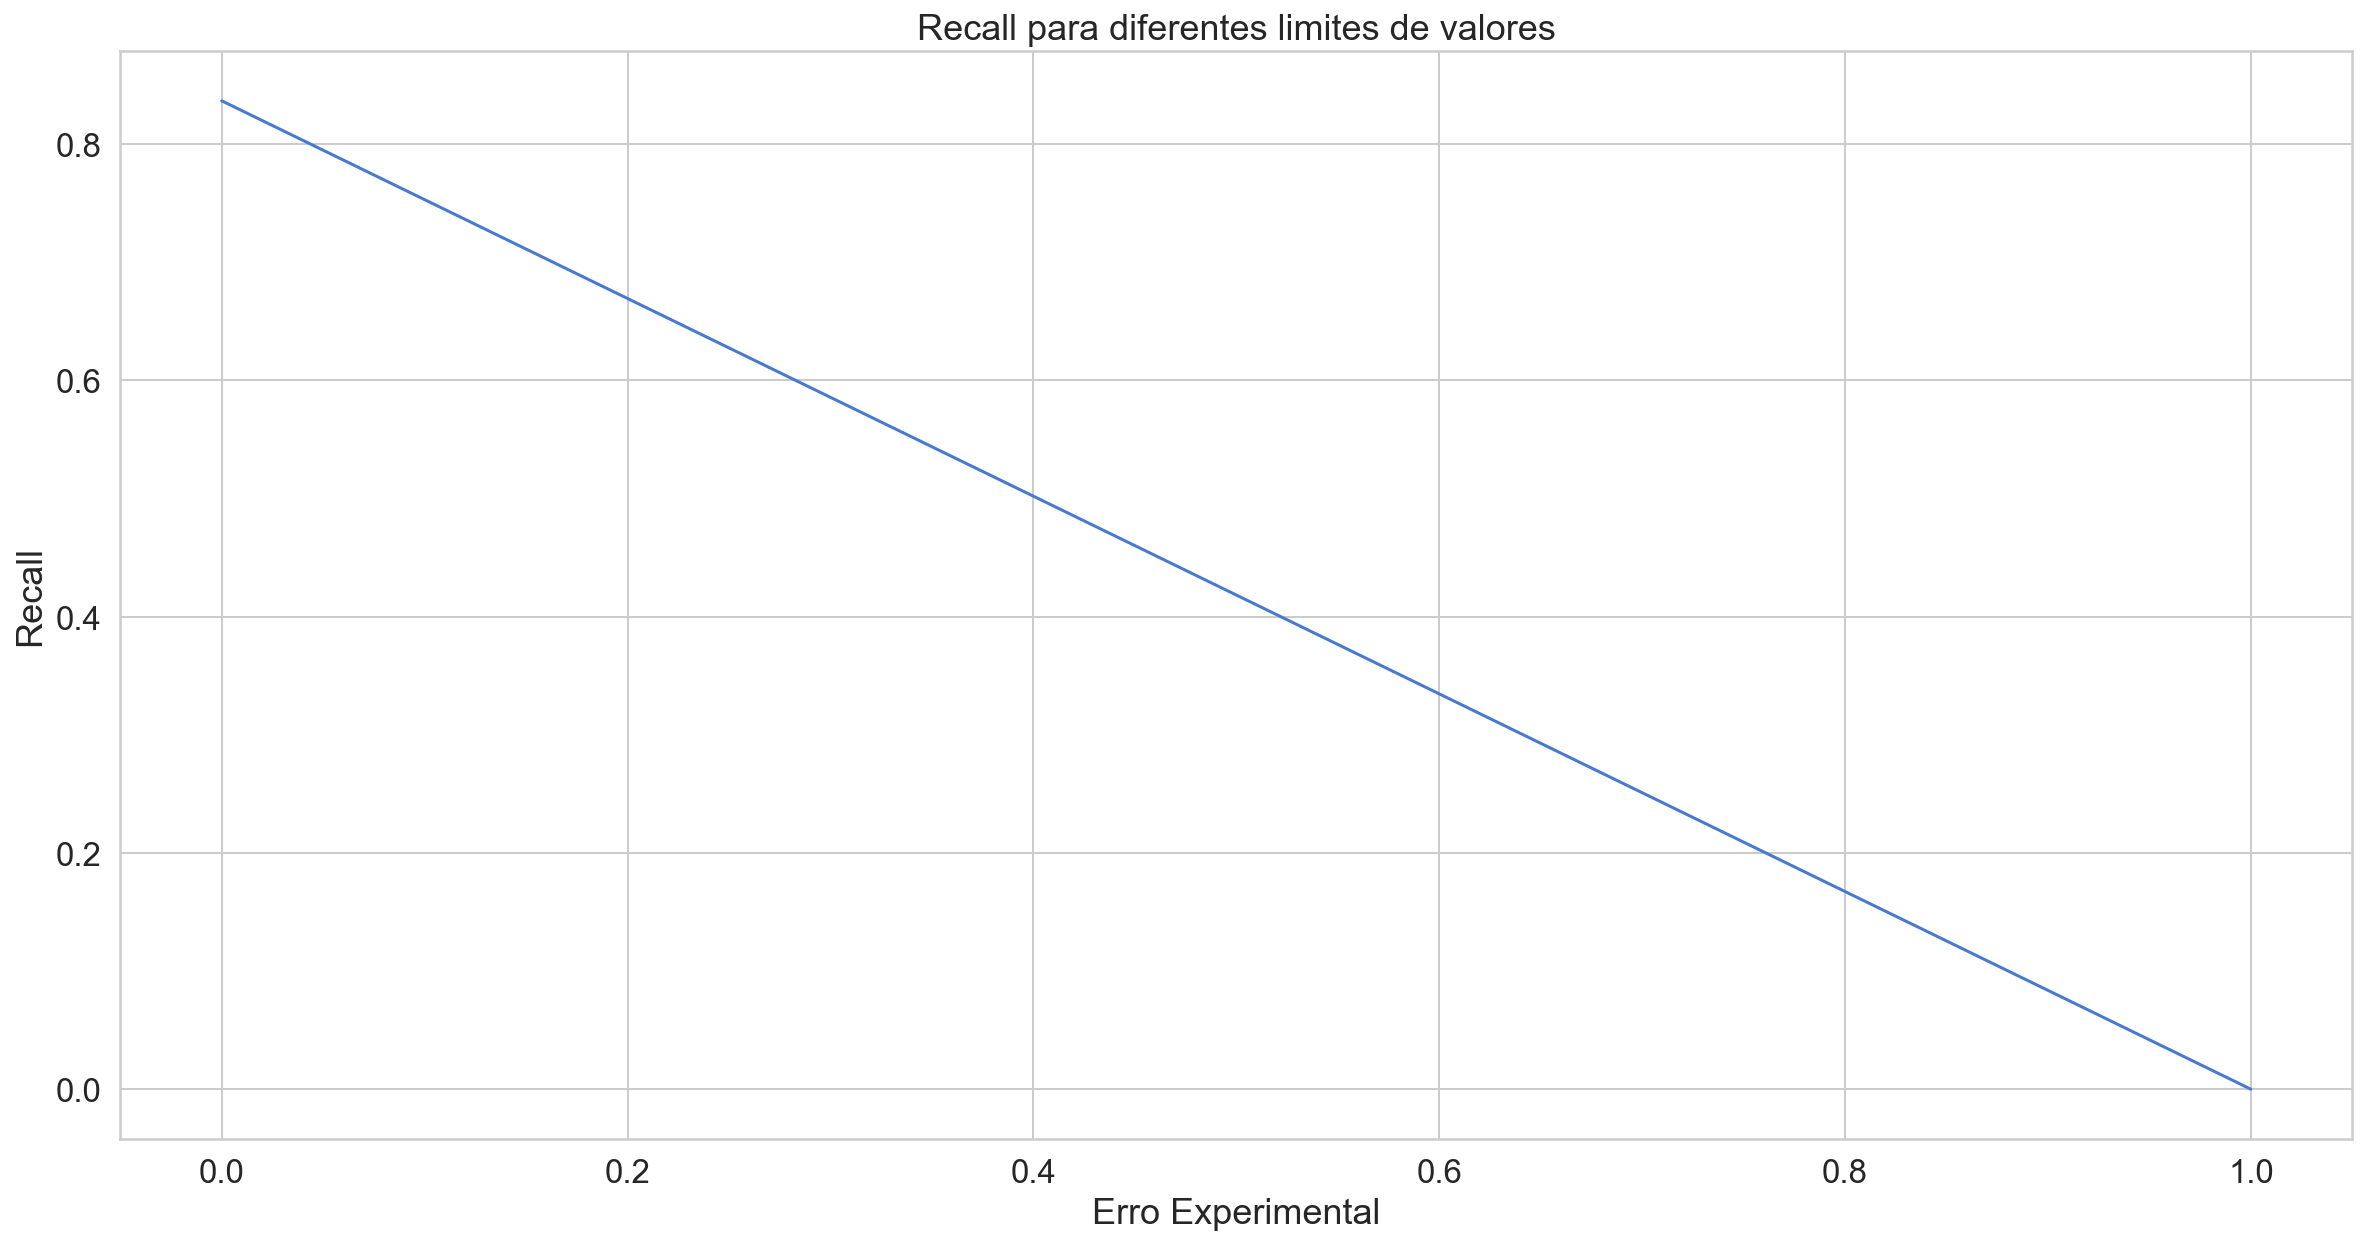

In [137]:
# Plote recall para diferentes limites
plt.plot(th, recall[1:], 'b', label='Limites-Recall curva')
plt.title('Recall para diferentes limites de valores')
plt.xlabel('Erro Experimental')
plt.ylabel('Recall')
plt.show()

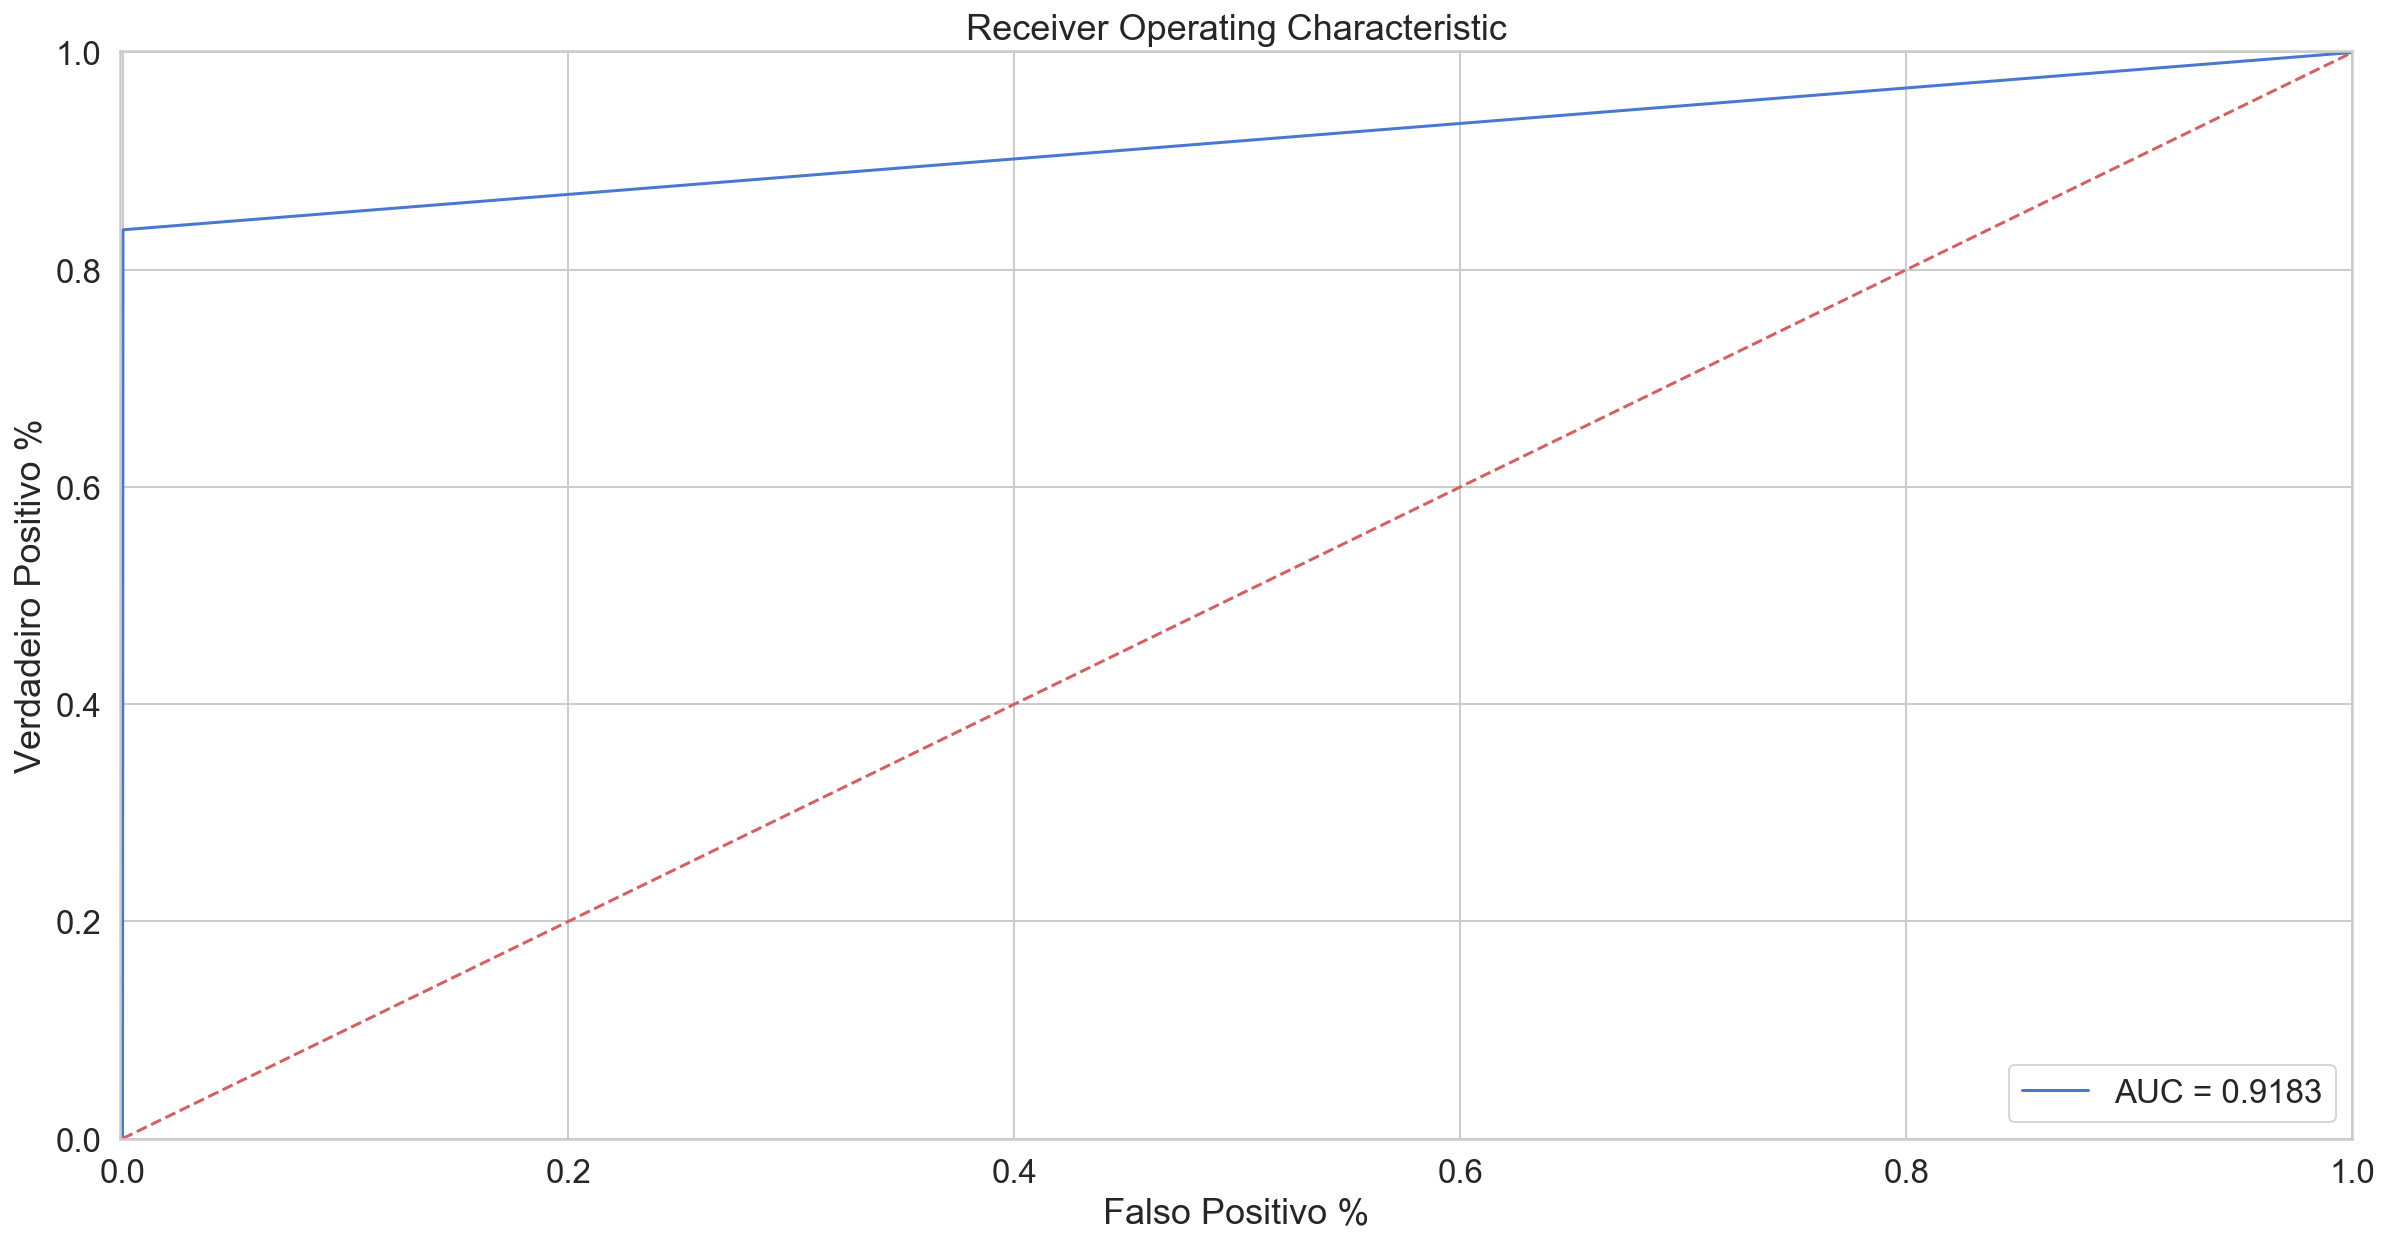

In [138]:
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict(X_test))
roc_auc = auc(fpr, tpr)

#Plote curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Verdadeiro Positivo %')
plt.xlabel('Falso Positivo %')
plt.show();

# Conclusões

A partir dos resultados acima podemos concluir que o Autoencoder não funciona tão bem quanto o modelo Random Forest. RandomForestClassifier é muito mais rápido e tem melhores valores de precisão e recall. O modelo tem muito menos falsos positivos comparado ao Autoencoder. Podemos concluir que, mesmo que o autoencoder seja uma boa opção, o Random Forest é uma ótima solução para esse tipo de problema.